In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)
from pandas.io.json import json_normalize

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [5]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [167]:
start_dt = '2021-06-03'
end_dt = '2021-06-17'

(1) Plot Hourly Media Cost, Advertiser Revenue, Margin per Hour

(2) Plot Cohorted Installs by Hour -> Recommendation on Budget Allocation by Hour

(3) Is the Budget allocation/Spend/ following hours where we see high Inventory/Users/Installs 

(4) Are we exhausting Budget in the first few mins of every hour? 

(5) Are there DT campaigns that are exhausting budget Before EOD

(6) Which Campaigns are budget capping? 

(7) % of Budget left

(8) Is the issue Auto-Pilot or ML Models

(9) Are we hitting tCPI or not? 

In [7]:
df = bigquery_client.query(f"""
select
    date
    , extract(month from date) as month
    , exchange_id
    , 'rows_new' as source
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
from stats.rows_new
group by 1,2,3
union all
select
    date
    , extract(month from date) as month
    , exchange_id
    , 'rows1' as source
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
from stats.rows1
group by 1,2,3
""").to_dataframe()
df = df.set_index('exchange_id').join(exchange.set_index('exchange_id'), how = 'left')
df.reset_index(inplace = True)
df

date  month source           cost exchange_name
exchange_id                                                       
1.0          2021-06-13      6  rows1  718381.056015         Fyber
1.0          2021-05-15      5  rows1  651929.674613         Fyber
1.0          2021-05-06      5  rows1  846516.801138         Fyber
1.0          2021-05-10      5  rows1  681414.584439         Fyber
1.0          2021-04-29      4  rows1  651260.470116         Fyber
...                 ...    ...    ...            ...           ...
NaN          2021-05-01      5  rows1       0.000000           NaN
NaN          2020-07-15      7  rows1       0.000000           NaN
NaN          2021-02-02      2  rows1       0.000000           NaN
NaN          2020-04-08      4  rows1       0.000000           NaN
NaN          2019-10-19     10  rows1       0.000000           NaN

[4217 rows x 5 columns]

In [23]:
df[df.date > datetime.date(2021,4,1)].pivot_table(values = 'cost', index = 'date', columns = 'source', aggfunc = np.sum).head(30)

source             rows1      rows_new
date                                  
2021-04-02  0.000000e+00  0.000000e+00
2021-04-03  0.000000e+00  0.000000e+00
2021-04-04  0.000000e+00  0.000000e+00
2021-04-05  0.000000e+00  0.000000e+00
2021-04-06  0.000000e+00  0.000000e+00
2021-04-07  0.000000e+00  0.000000e+00
2021-04-08  0.000000e+00  0.000000e+00
2021-04-09  1.226885e+00  1.226885e+00
2021-04-10  7.685374e+01  7.685374e+01
2021-04-11  3.870604e+02  3.870604e+02
2021-04-12  5.027784e+05  5.027784e+05
2021-04-13  9.142767e+05  9.142767e+05
2021-04-14  1.065749e+06  1.065749e+06
2021-04-15  9.884661e+05  9.884661e+05
2021-04-16  9.291292e+05  9.291292e+05
2021-04-17  8.782315e+05  8.782315e+05
2021-04-18  1.369864e+06  1.369864e+06
2021-04-19  1.876840e+06  1.876840e+06
2021-04-20  1.938532e+06  1.938532e+06
2021-04-21  2.014690e+06  2.014690e+06
2021-04-22  1.832988e+06  1.832988e+06
2021-04-23  1.910336e+06  1.910336e+06
2021-04-24  1.947483e+06  1.947483e+06
2021-04-25  1.852832e+06  1.852832e+06
2021-04-26  1.931665e+06  1.931665e+06
2021-04-27  1.870123e+06  1.870123e+06
2021-04-28  1.889121e+06  1.889121e+06
2021-04-29  2.017211e+06  2.017211e+06
2021-04-30  1.995052e+06  1.995052e+06
2021-05-01  1.995675e+06  1.995675e+06

In [23]:
tz = pd.read_csv('files/tz_bycountry.csv')
tz['offset_hrs'] = pd.to_numeric(tz['GMT Offset'].str[:3], errors = 'coerce') + pd.to_numeric(tz['GMT Offset'].str[-2:], errors = 'coerce')/60
tz_bycountry = tz.groupby('Country Code')['offset_hrs'].mean()
df_offset = pd.merge(df, tz_bycountry, how = 'left', left_on = 'country', right_on = 'Country Code')
df_offset

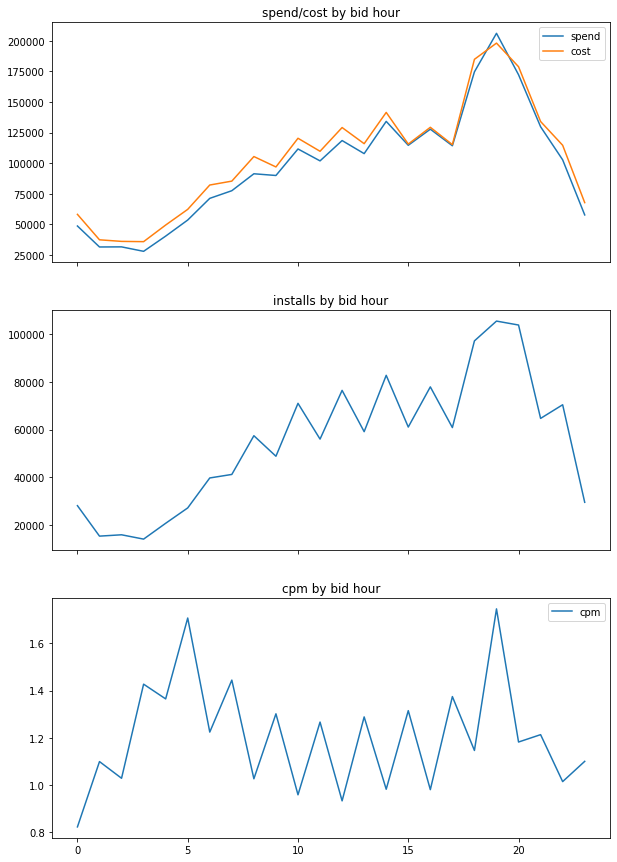

In [6]:
df_offset['hour_local'] = round(df_offset.hour + df_offset.offset_hrs.astype('int', errors = 'ignore'),0).astype(int, errors = 'ignore')
df_offset.loc[df_offset.hour_local > 23, 'hour_local'] = df_offset['hour_local'] - 24
df_offset.loc[df_offset.hour_local < 0, 'hour_local'] = df_offset['hour_local'] + 24

pvt = df_offset.pivot_table(values = ['impressions','clicks','installs','spend','cost','bid'], index = 'hour_local', aggfunc = np.sum)
pvt['bpm'] = 1000*pvt['bid']/pvt['impressions']
pvt['cpm'] = 1000*pvt['cost']/pvt['impressions']

fig, ax = plt.subplots(3,1, figsize = (10,15), sharex = True)
ax[0].plot(pvt[['spend','cost']])
ax[0].set_title('spend/cost by bid hour')
ax[0].legend(['spend','cost'])
ax[1].plot(pvt[['installs']])
ax[1].set_title('installs by bid hour')
ax[2].plot(pvt[['cpm']])
ax[2].set_title('cpm by bid hour')
ax[2].legend(['cpm'])

Text(0.5, 1.0, 'cpm by bid hour (local) (AP)')

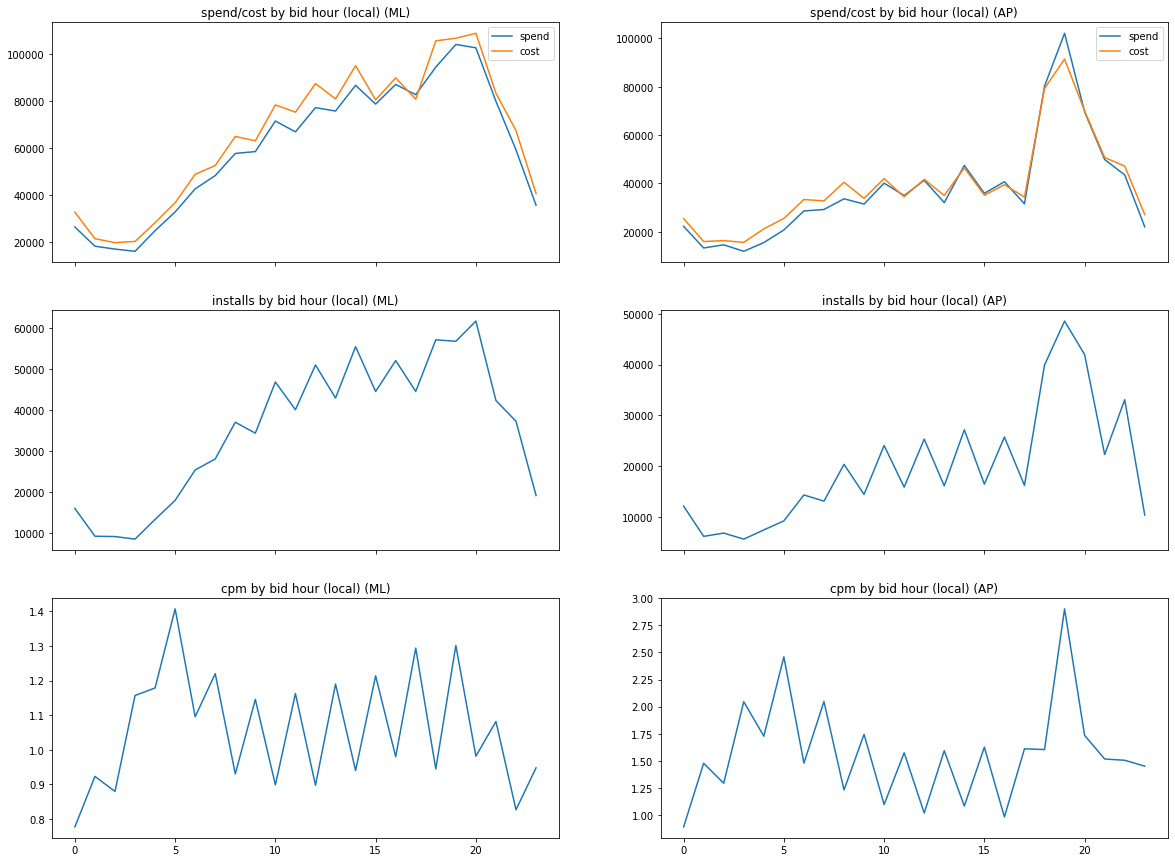

In [7]:
pvt_ml = df_offset[df_offset.bidder == 'ML'].pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'hour_local', aggfunc = np.sum)
pvt_ap = df_offset[df_offset.bidder == 'AutoPilot'].pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'hour_local', aggfunc = np.sum)
pvt_ml['cpm'] = 1000*pvt_ml['cost']/pvt_ml['impressions']
pvt_ap['cpm'] = 1000*pvt_ap['cost']/pvt_ap['impressions']

fig, ax = plt.subplots(3,2, figsize = (20,15), sharex = True)
ax[0,0].plot(pvt_ml[['spend','cost']])
ax[0,0].set_title('spend/cost by bid hour (local) (ML)')
ax[0,0].legend(['spend','cost'])
ax[1,0].plot(pvt_ml[['installs']])
ax[1,0].set_title('installs by bid hour (local) (ML)')
ax[2,0].plot(pvt_ml[['cpm']])
ax[2,0].set_title('cpm by bid hour (local) (ML)')
ax[0,1].plot(pvt_ap[['spend','cost']])
ax[0,1].set_title('spend/cost by bid hour (local) (AP)')
ax[0,1].legend(['spend','cost'])
ax[1,1].plot(pvt_ap[['installs']])
ax[1,1].set_title('installs by bid hour (local) (AP)')
ax[2,1].plot(pvt_ap[['cpm']])
ax[2,1].set_title('cpm by bid hour (local) (AP)')

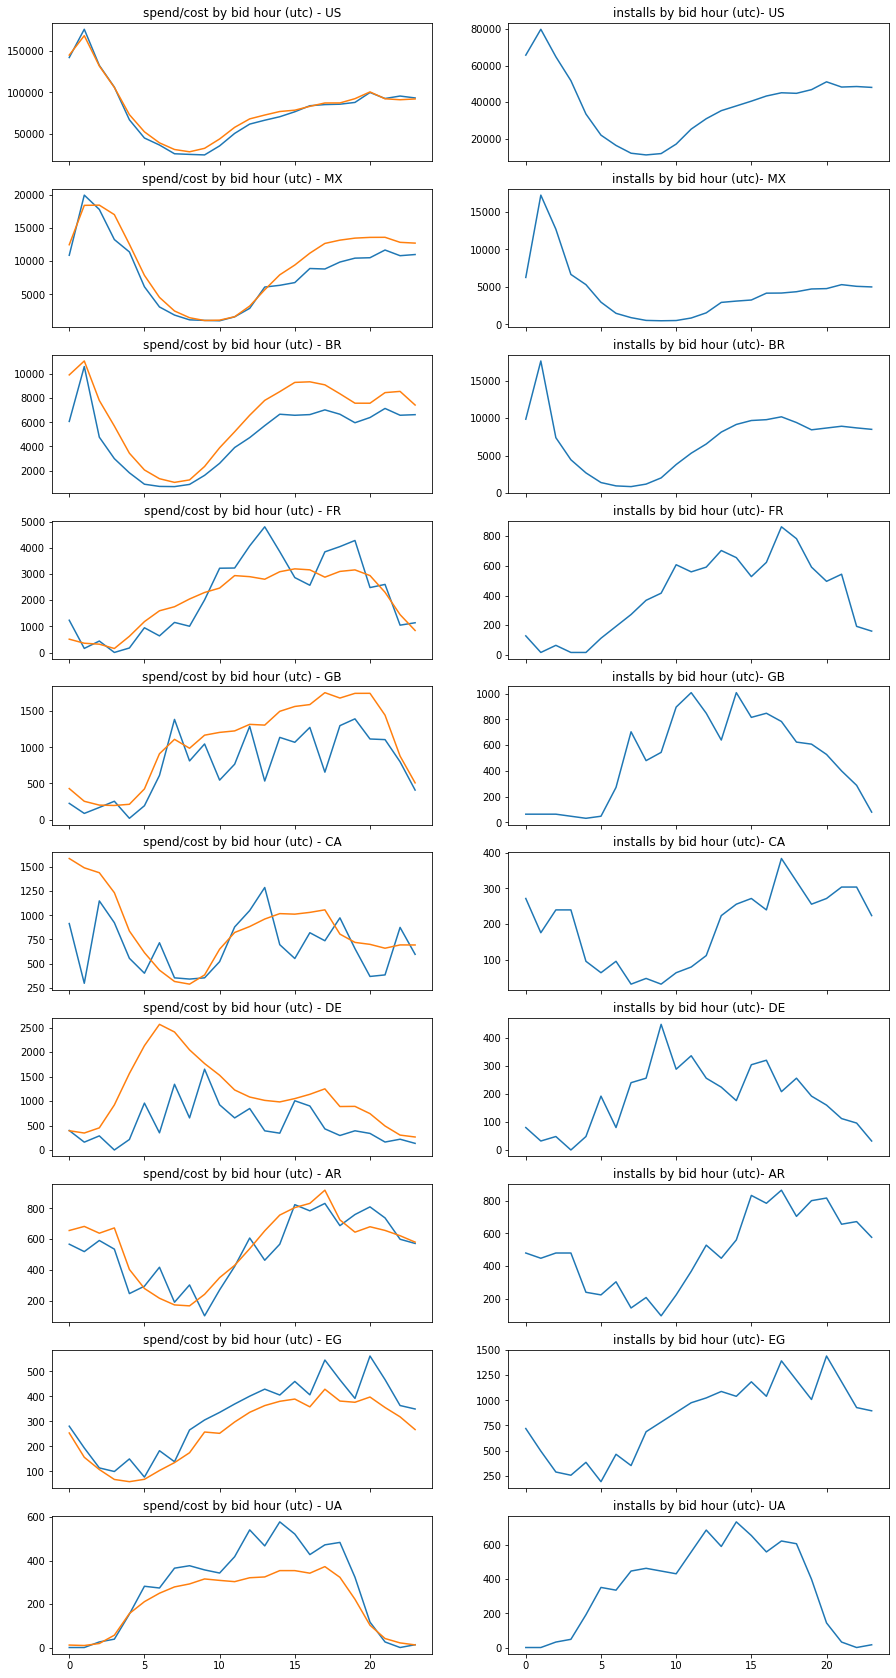

In [8]:
top_countries = df_offset.groupby('country')['spend'].sum().sort_values(ascending = False).index[:10].to_list()

fig, ax = plt.subplots(len(top_countries),2, figsize = (15,30), sharex = True)
    
for n in range(len(top_countries)):
    df_filtered = df_offset[df_offset.country == top_countries[n]]
    pvt = df_filtered.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'hour', aggfunc = np.sum)

    ax[n,0].plot(pvt[['spend','cost']])
    ax[n,0].set_title('spend/cost by bid hour (utc) - {}'.format(top_countries[n]))
    ax[n,1].plot(pvt[['installs']])
    ax[n,1].set_title('installs by bid hour (utc)- {}'.format(top_countries[n]))

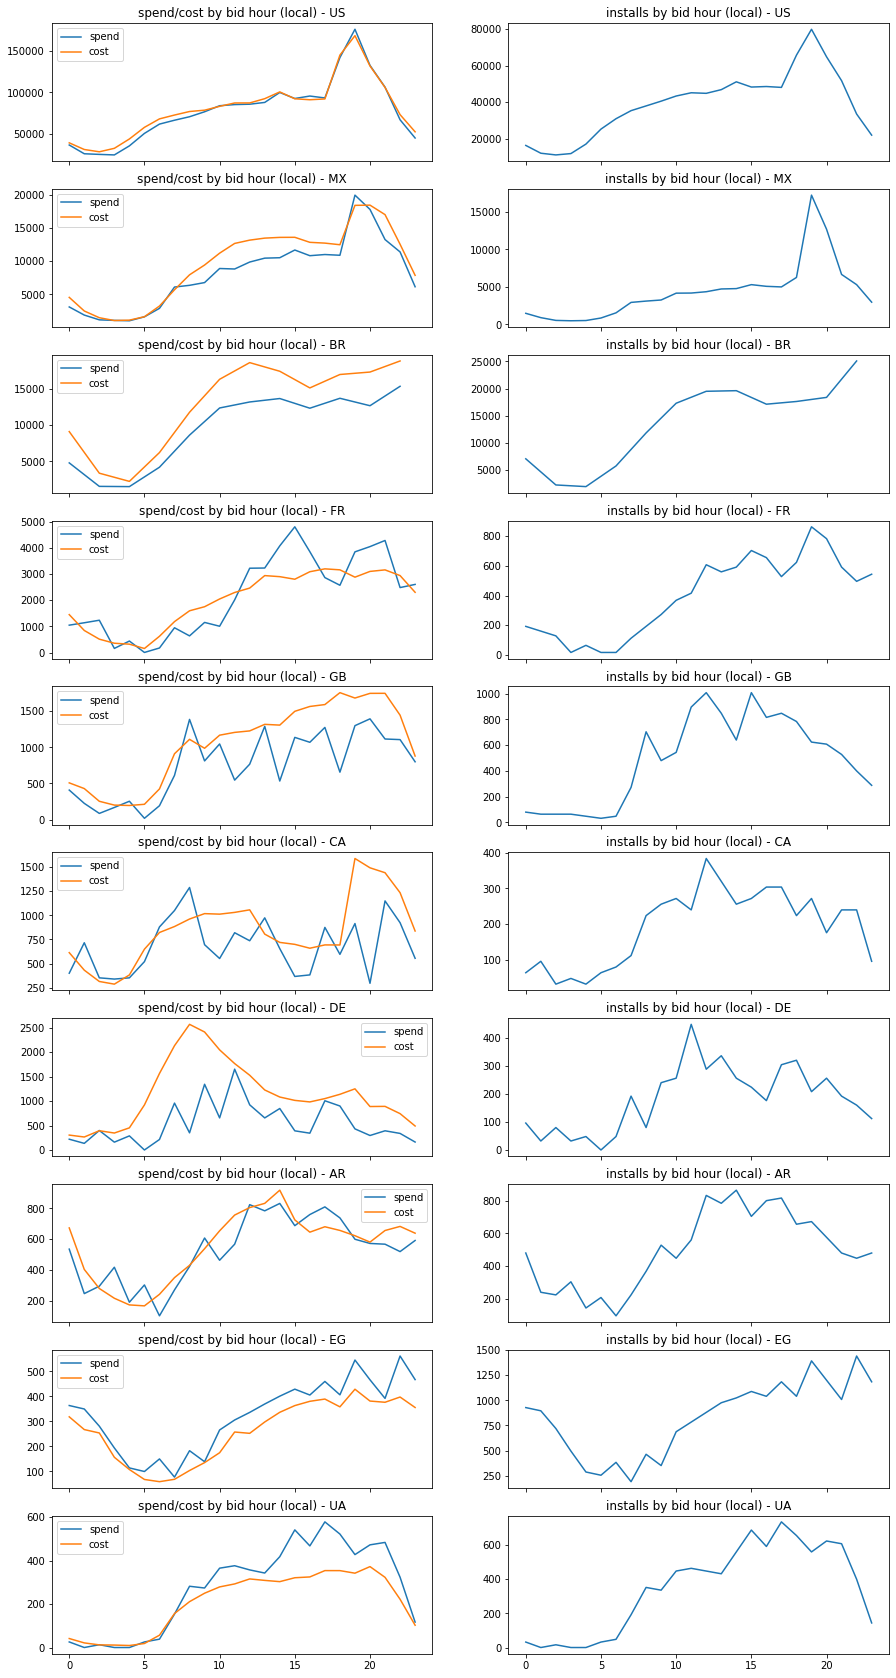

In [9]:


fig, ax = plt.subplots(len(top_countries),2, figsize = (15,30), sharex = True)
    
for n in range(len(top_countries)):
    df_filtered = df_offset[df_offset.country == top_countries[n]]
    pvt = df_filtered.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'hour_local', aggfunc = np.sum)

    ax[n,0].plot(pvt[['spend','cost']])
    ax[n,0].set_title('spend/cost by bid hour (local) - {}'.format(top_countries[n]))
    ax[n,0].legend(['spend','cost'])
    ax[n,1].plot(pvt[['installs']])
    ax[n,1].set_title('installs by bid hour (local) - {}'.format(top_countries[n]))

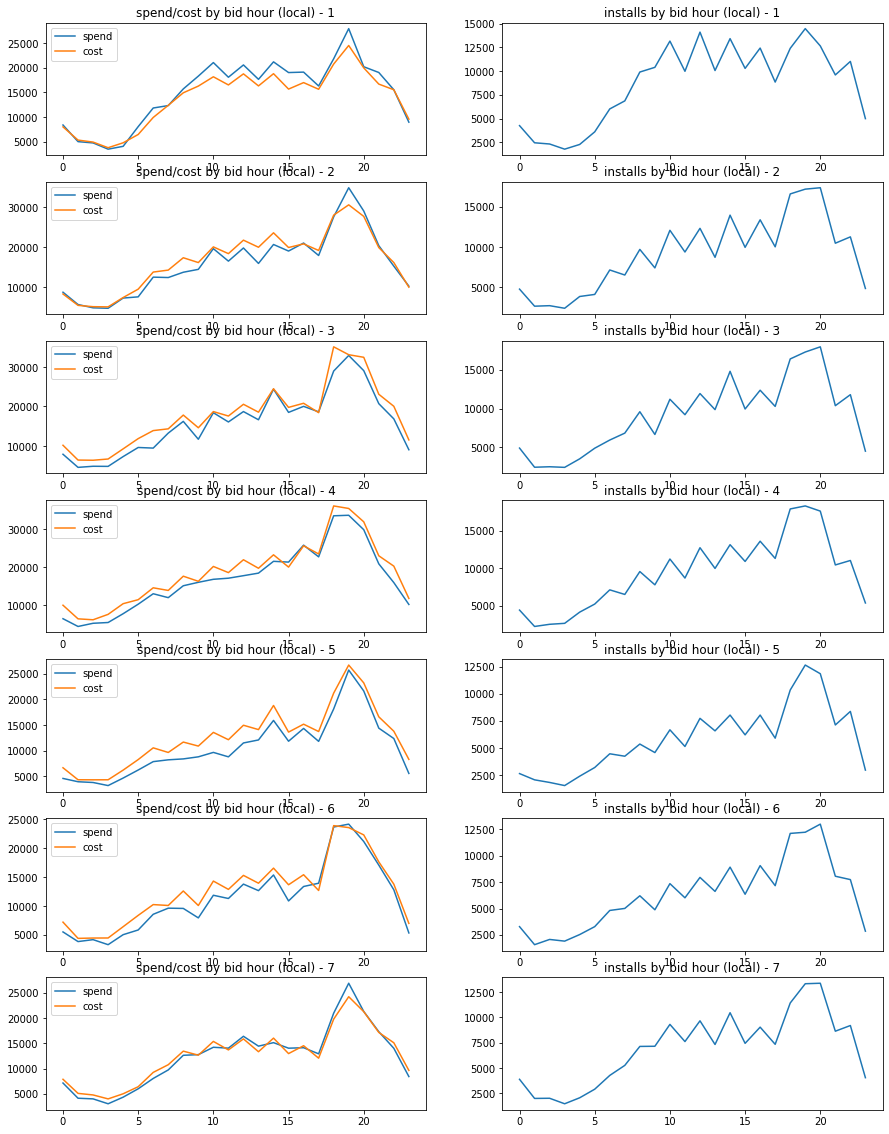

In [10]:
fig, ax = plt.subplots(7,2, figsize = (15,20))

for n in list(range(1,8)):
    df_filtered = df_offset[df_offset.dow == n]
    pvt = df_filtered.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'hour_local', aggfunc = np.sum)

    ax[n-1,0].plot(pvt[['spend','cost']])
    ax[n-1,0].set_title('spend/cost by bid hour (local) - {}'.format(n))
    ax[n-1,0].legend(['spend','cost'])
    ax[n-1,1].plot(pvt[['installs']])
    ax[n-1,1].set_title('installs by bid hour (local) - {}'.format(n))

(0.0, 2.0)

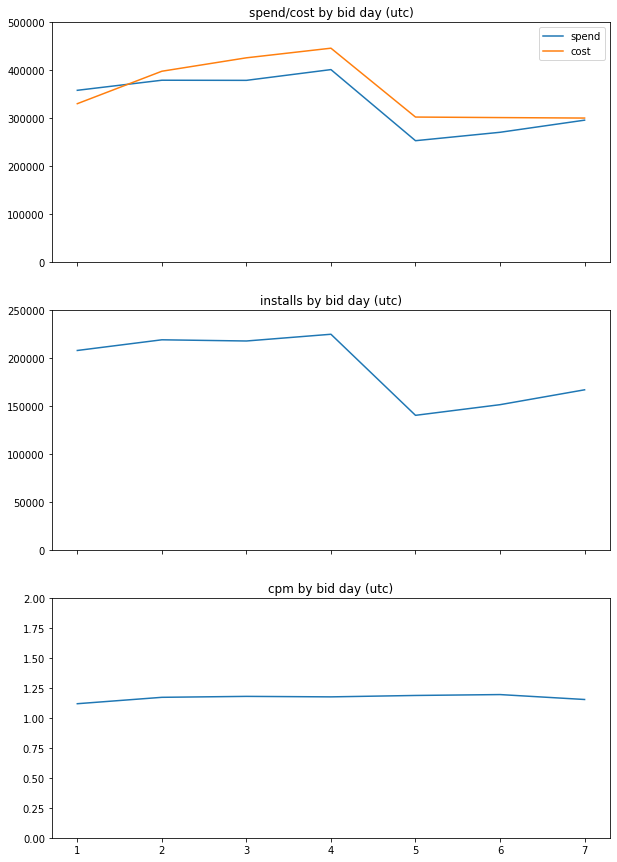

In [11]:
fig, ax = plt.subplots(3,1, figsize = (10,15), sharex = True)

pvt = df_offset.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'dow', aggfunc = np.sum)
pvt['cpm'] = 1000*pvt['cost']/pvt['impressions']
ax[0].plot(pvt[['spend','cost']])
ax[0].set_title('spend/cost by bid day (utc)')
ax[0].legend(['spend','cost'])
ax[0].set_ylim(0,500000)
ax[1].plot(pvt[['installs']])
ax[1].set_title('installs by bid day (utc)')
ax[1].set_ylim(0,250000)
ax[2].plot(pvt[['cpm']])
ax[2].set_title('cpm by bid day (utc)')
ax[2].set_ylim(0,2)

(0.0, 2.0)

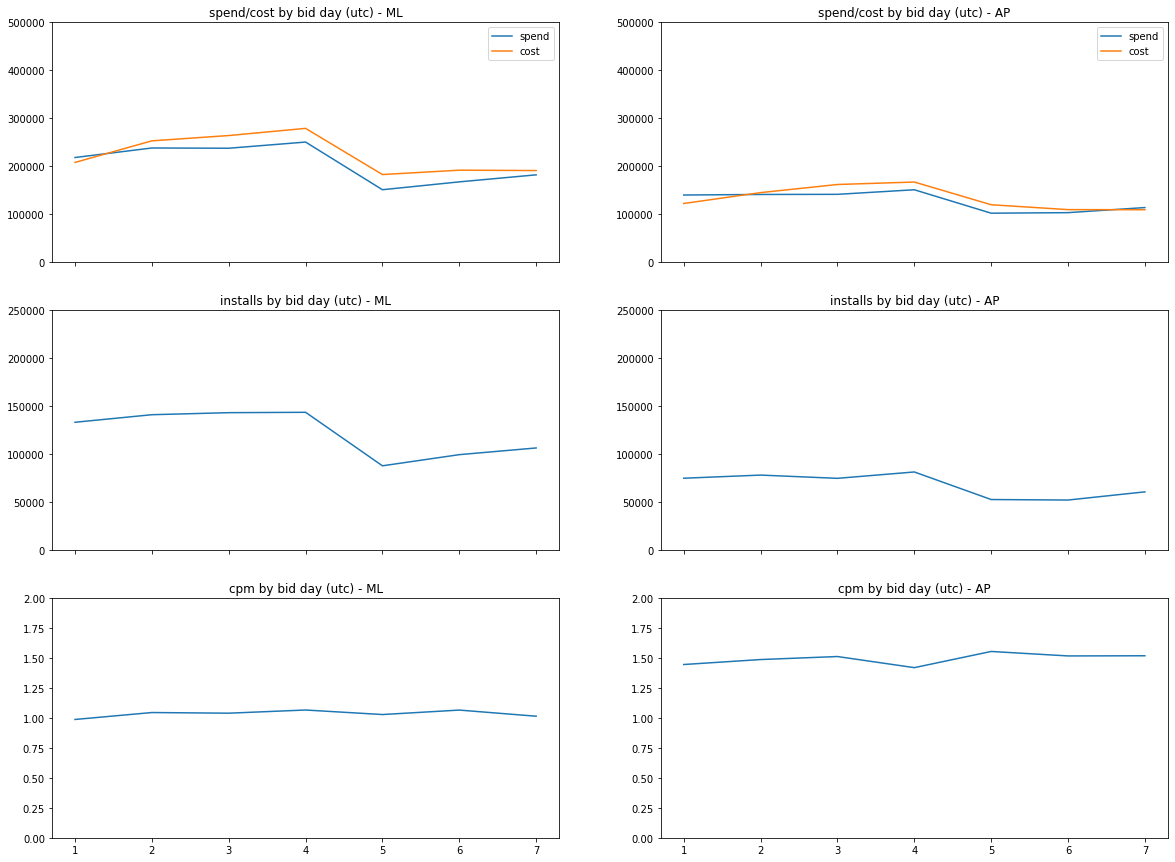

In [12]:
fig, ax = plt.subplots(3,2, figsize = (20,15), sharex = True)

pvt = df_offset.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = ['bidder','dow'], aggfunc = np.sum)
pvt['cpm'] = 1000*pvt['cost']/pvt['impressions']
ax[0,0].plot(pvt.loc[pvt.index.get_level_values(0) == 'ML',['spend','cost']].droplevel(0))
ax[0,0].set_title('spend/cost by bid day (utc) - ML')
ax[0,0].legend(['spend','cost'])
ax[0,0].set_ylim(0,500000)
ax[1,0].plot(pvt.loc[pvt.index.get_level_values(0) == 'ML',['installs']].droplevel(0))
ax[1,0].set_title('installs by bid day (utc) - ML')
ax[1,0].set_ylim(0,250000)
ax[2,0].plot(pvt.loc[pvt.index.get_level_values(0) == 'ML',['cpm']].droplevel(0))
ax[2,0].set_title('cpm by bid day (utc) - ML')
ax[2,0].set_ylim(0,2)
ax[0,1].plot(pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot',['spend','cost']].droplevel(0))
ax[0,1].set_title('spend/cost by bid day (utc) - AP')
ax[0,1].legend(['spend','cost'])
ax[0,1].set_ylim(0,500000)
ax[1,1].plot(pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot',['installs']].droplevel(0))
ax[1,1].set_title('installs by bid day (utc) - AP')
ax[1,1].set_ylim(0,250000)
ax[2,1].plot(pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot',['cpm']].droplevel(0))
ax[2,1].set_title('cpm by bid day (utc) - AP')
ax[2,1].set_ylim(0,2)

## intra hour

Text(0.5, 1.0, 'impressions by minute of hour')

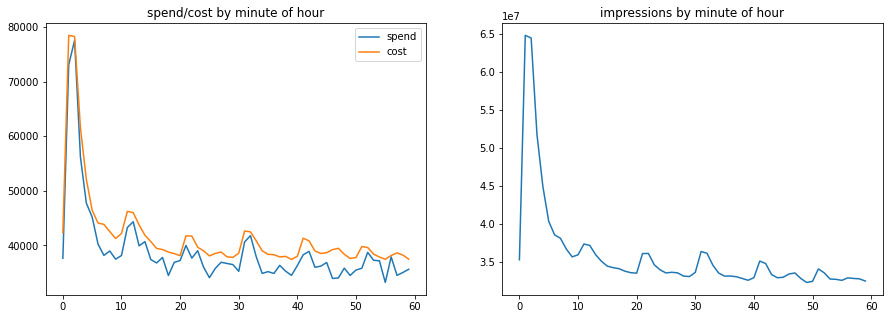

In [13]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
pvt = df_offset.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'minute', aggfunc = np.sum)

ax[0].plot(pvt[['spend','cost']])
ax[0].set_title('spend/cost by minute of hour')
ax[0].legend(['spend','cost'])
ax[1].plot(pvt[['impressions']])
ax[1].set_title('impressions by minute of hour')

Text(0.5, 1.0, 'impressions by minute of hour (AP)')

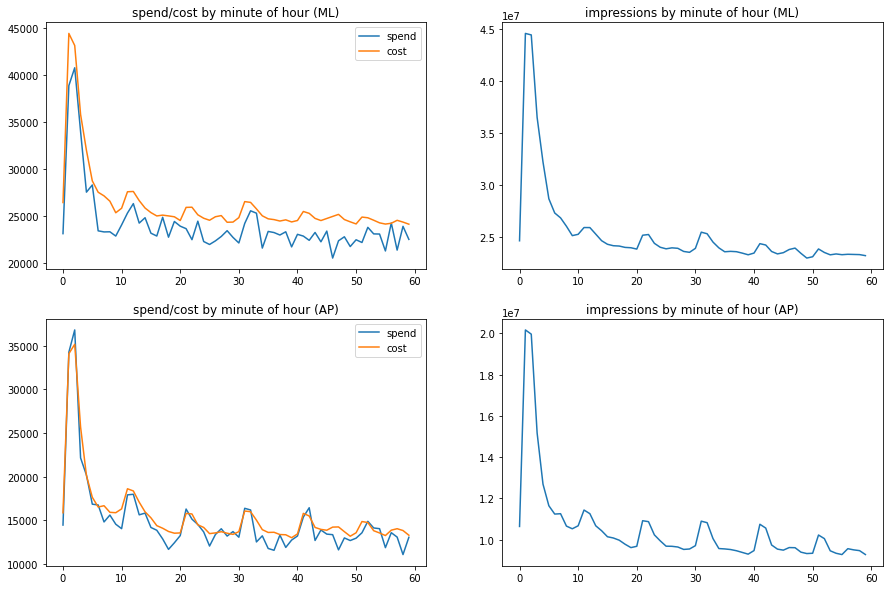

In [14]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
pvt = df_offset.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = ['bidder','minute'], aggfunc = np.sum)

ax[0,0].plot(pvt.loc[pvt.index.get_level_values(0) == 'ML', ['spend','cost']].droplevel(0))
ax[0,0].set_title('spend/cost by minute of hour (ML)')
ax[0,0].legend(['spend','cost'])
ax[0,1].plot(pvt.loc[pvt.index.get_level_values(0) == 'ML', ['impressions']].droplevel(0))
ax[0,1].set_title('impressions by minute of hour (ML)')
ax[1,0].plot(pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot', ['spend','cost']].droplevel(0))
ax[1,0].set_title('spend/cost by minute of hour (AP)')
ax[1,0].legend(['spend','cost'])
ax[1,1].plot(pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot', ['impressions']].droplevel(0))
ax[1,1].set_title('impressions by minute of hour (AP)')

Text(0.5, 1.0, 'impression/install share of voice by minute of hour (AP)')

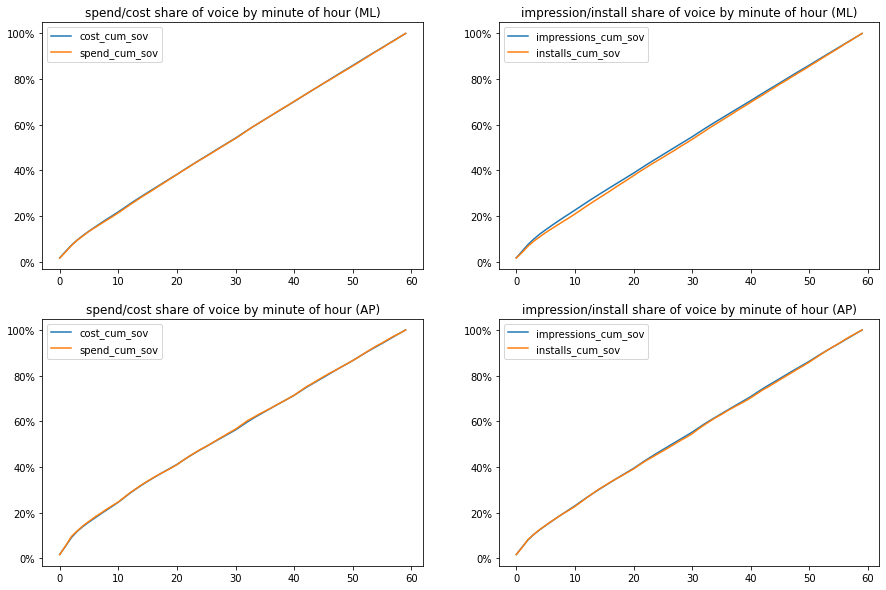

In [15]:
pvt['cost_cum_sov'] = pvt['cost'].groupby('bidder').cumsum()/pvt['cost'].groupby('bidder').sum()
pvt['spend_cum_sov'] = pvt['spend'].groupby('bidder').cumsum()/pvt['spend'].groupby('bidder').sum()
pvt['impressions_cum_sov'] = pvt['impressions'].groupby('bidder').cumsum()/pvt['impressions'].groupby('bidder').sum()
pvt['installs_cum_sov'] = pvt['installs'].groupby('bidder').cumsum()/pvt['installs'].groupby('bidder').sum()

fig, ax = plt.subplots(2,2, figsize = (15,10))
ax[0,0].plot(100*pvt.loc[pvt.index.get_level_values(0) == 'ML', ['cost_cum_sov','spend_cum_sov']].droplevel(0))
ax[0,0].legend(['cost_cum_sov','spend_cum_sov'])
ax[0,0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0,0].set_title('spend/cost share of voice by minute of hour (ML)')
ax[0,1].plot(100*pvt.loc[pvt.index.get_level_values(0) == 'ML', ['impressions_cum_sov','installs_cum_sov']].droplevel(0))
ax[0,1].legend(['impressions_cum_sov','installs_cum_sov'])
ax[0,1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0,1].set_title('impression/install share of voice by minute of hour (ML)')
ax[1,0].plot(100*pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot', ['cost_cum_sov','spend_cum_sov']].droplevel(0))
ax[1,0].legend(['cost_cum_sov','spend_cum_sov'])
ax[1,0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1,0].set_title('spend/cost share of voice by minute of hour (AP)')
ax[1,1].plot(100*pvt.loc[pvt.index.get_level_values(0) == 'AutoPilot', ['impressions_cum_sov','installs_cum_sov']].droplevel(0))
ax[1,1].legend(['impressions_cum_sov','installs_cum_sov'])
ax[1,1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1,1].set_title('impression/install share of voice by minute of hour (AP)')

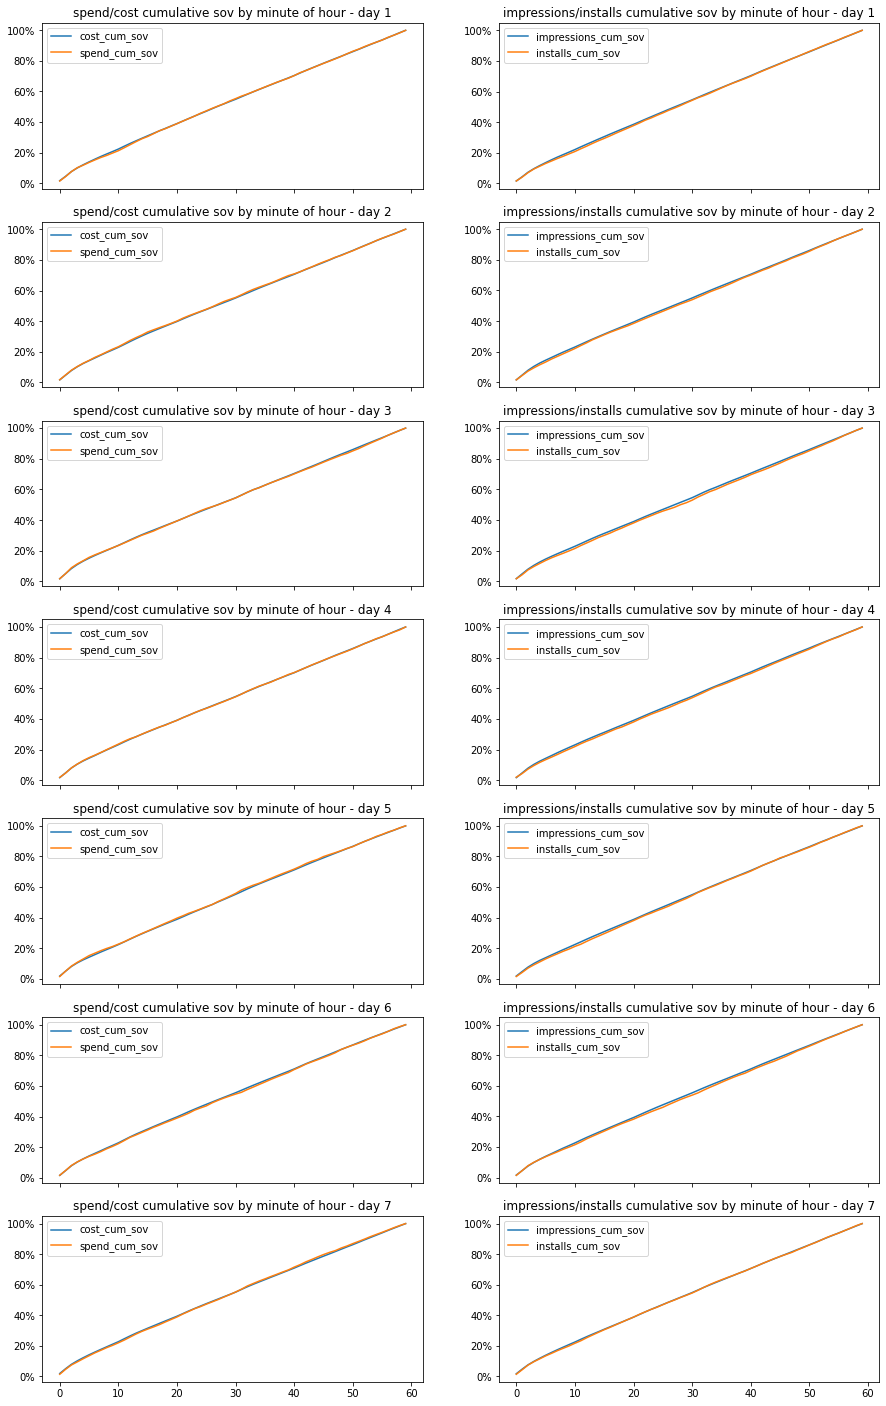

In [16]:
fig, ax = plt.subplots(7,2, figsize = (15,25), sharex = True)

for n in list(range(1,8)):
    df_filtered = df_offset[df_offset.dow == n]
    pvt = df_filtered.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'minute', aggfunc = np.sum)
    pvt['cost_cum_sov'] = pvt['cost'].cumsum()/pvt['cost'].sum()
    pvt['spend_cum_sov'] = pvt['spend'].cumsum()/pvt['spend'].sum()
    pvt['impressions_cum_sov'] = pvt['impressions'].cumsum()/pvt['impressions'].sum()
    pvt['installs_cum_sov'] = pvt['installs'].cumsum()/pvt['installs'].sum()
    ax[n-1,0].plot(100*pvt[['cost_cum_sov','spend_cum_sov']])
    ax[n-1,0].legend(['cost_cum_sov','spend_cum_sov'])
    ax[n-1,0].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[n-1,0].set_title('spend/cost cumulative sov by minute of hour - day {}'.format(n))
    ax[n-1,1].plot(100*pvt[['impressions_cum_sov','installs_cum_sov']])
    ax[n-1,1].legend(['impressions_cum_sov','installs_cum_sov'])
    ax[n-1,1].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[n-1,1].set_title('impressions/installs cumulative sov by minute of hour - day {}'.format(n))

## Campaign capping hour

In [168]:
df_capping = bigquery_client.query(f"""
select
    case when ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , case when cr_model = 'production' or ctr_model = 'production' then 'AutoPilot' else 'ML' end as bidder
    , date
    , extract(dayofweek from timestamp) as dow
    , extract(hour from timestamp) as hour
    , r.ssb_campaign_uuid
    , c.name
    , r.country
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
from stats.rows1 r
join metadata.dt_campaigns c
    on r.ssb_campaign_uuid = c.uuid
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(r.id,1) = '0'
group by 1,2,3,4,5,6,7,8
""").to_dataframe()
df_capping['date'] = df_capping['date'].astype('datetime64')
df_capping['spend'] = df_capping['spend'].astype('float')
df_capping['cost'] = df_capping['cost'].astype('float')
df_capping

buyer bidder       date  dow  hour                 ssb_campaign_uuid  \
0        DT     ML 2021-06-08    3    13  239c775280e160411963f7001380dd70   
1        DT     ML 2021-06-09    4    17  8f6af55d3b890df1566e59c4bcf13d3c   
2        DT     ML 2021-06-09    4    23  b5100ac9db3b4065435f41827807fae6   
3        DT     ML 2021-06-08    3    17  a1dd9f2ab72d27d0e3cc234fefd3b03e   
4        DT     ML 2021-06-09    4    14  b5100ac9db3b4065435f41827807fae6   
...     ...    ...        ...  ...   ...                               ...   
72773    DT     ML 2021-06-16    4     3  95f82f59fd9cac3b272b560f722e35d6   
72774    DT     ML 2021-06-12    7    16  95f82f59fd9cac3b272b560f722e35d6   
72775    DT     ML 2021-06-09    4    19  95f82f59fd9cac3b272b560f722e35d6   
72776    DT     ML 2021-06-11    6    23  95f82f59fd9cac3b272b560f722e35d6   
72777    DT     ML 2021-06-17    5    13  95f82f59fd9cac3b272b560f722e35d6   

                                               name country  impressions  \
0                      Android-Twitter-Twitter-TH-4      TH       119264   
1                      Pandora - Pandora - US - iOS      US        58208   
2                      Android-Twitter-Twitter-MX-2      MX        52016   
3                      Android-Twitter-Twitter-EG-4      EG       261968   
4                      Android-Twitter-Twitter-MX-2      MX        28800   
...                                             ...     ...          ...   
72773  Particle Media – News Break – US – All – GP2      US        60560   
72774  Particle Media – News Break – US – All – GP2      US        57984   
72775  Particle Media – News Break – US – All – GP2      US        64944   
72776  Particle Media – News Break – US – All – GP2      US        49280   
72777  Particle Media – News Break – US – All – GP2      US        99408   

       clicks  installs  spend        cost  
0        6656        32  110.4  153.318945  
1        1728        16   64.0   45.654574  
2        3904       224  224.0   84.202150  
3       15568        32  160.0  329.788243  
4        2416       240  240.0   51.743215  
...       ...       ...    ...         ...  
72773     304        16   48.0   81.059219  
72774     192         0    0.0   95.406800  
72775     576        16   48.0  114.090949  
72776     368        16   48.0   64.553687  
72777     496         0    0.0  115.044001  

[72778 rows x 13 columns]

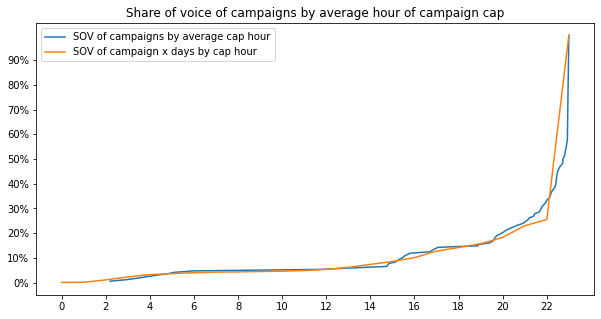

In [169]:
df_capping['cap_hour'] = df_capping[df_capping.impressions > 0].groupby(['ssb_campaign_uuid','date'])['hour'].transform('max')
cap_hour_by_campaign_date = df_capping.pivot_table(values = ['cap_hour'], index = ['ssb_campaign_uuid','date'], aggfunc = 'max').reset_index()
cap_hour_campaign_counts = pd.DataFrame(cap_hour_by_campaign_date.groupby('cap_hour')['ssb_campaign_uuid'].count())
cap_hour_campaign_counts['campaign_day_sov'] = cap_hour_campaign_counts['ssb_campaign_uuid'].cumsum()/cap_hour_campaign_counts['ssb_campaign_uuid'].sum()

cap_hour_by_campaign_avg = cap_hour_by_campaign_date.groupby('ssb_campaign_uuid')['cap_hour'].mean().reset_index()
cum_avg_cap_hour_counts = pd.DataFrame(cap_hour_by_campaign_avg.groupby('cap_hour')['ssb_campaign_uuid'].count())
cum_avg_cap_hour_counts['avg_campaign_sov'] = cum_avg_cap_hour_counts['ssb_campaign_uuid'].cumsum()/cum_avg_cap_hour_counts['ssb_campaign_uuid'].sum()

fig, ax = plt.subplots(figsize = (10,5)) 
ax.plot(100*cum_avg_cap_hour_counts[['avg_campaign_sov']])
ax.plot(100*cap_hour_campaign_counts[['campaign_day_sov']])
ax.set_title('Share of voice of campaigns by average hour of campaign cap')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(np.arange(0,24,2))
plt.yticks(np.arange(0,100,10))
ax.legend(['SOV of campaigns by average cap hour', 'SOV of campaign x days by cap hour'])

Text(0.5, 1.0, '# of campaigns with impressions by hour, limited by avg cap hour')

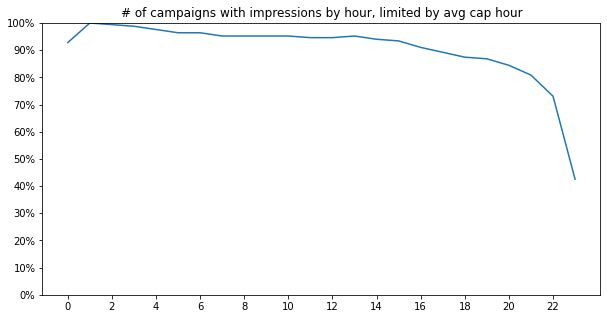

In [170]:
imp_by_campaign_hour = df_capping[df_capping.impressions > 0].pivot_table(values = ['impressions'], index = ['ssb_campaign_uuid','hour'], aggfunc = 'mean').reset_index()
cap_hour_by_campaign = df_capping[df_capping.impressions > 0].groupby('ssb_campaign_uuid')['cap_hour'].mean()
imp_by_campaign_hour = imp_by_campaign_hour.set_index('ssb_campaign_uuid').join(cap_hour_by_campaign)
imp_by_campaign_hour = imp_by_campaign_hour.loc[imp_by_campaign_hour.hour <= imp_by_campaign_hour.cap_hour].reset_index()

campaigns_by_hour = imp_by_campaign_hour.pivot_table(values = ['ssb_campaign_uuid'], index = 'hour', aggfunc = lambda x:len(x.unique()))
campaigns_by_hour['sov_spending'] = campaigns_by_hour['ssb_campaign_uuid']/campaigns_by_hour['ssb_campaign_uuid'].max()
campaigns_by_hour['sov_spending']
fig, ax = plt.subplots(figsize = (10,5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xticks(np.arange(0,24,2))
plt.yticks(np.arange(0,1.1,.1))
plt.ylim(0,1)
plt.plot(campaigns_by_hour['sov_spending'])
plt.title('# of campaigns with impressions by hour, limited by avg cap hour')

Text(0.5, 1.0, 'Share of voice of campaign x days by hour of campaign cap (DT only)')

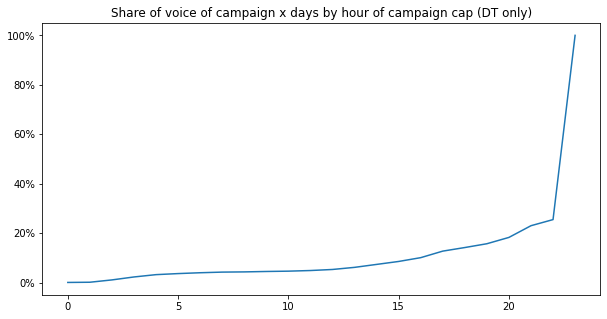

In [171]:
cap_hour_by_campaign_date = df_capping[df_capping.buyer == 'DT'].pivot_table(values = ['cap_hour'], index = ['ssb_campaign_uuid','date'], aggfunc = 'max').reset_index()
cap_hour_counts = pd.DataFrame(cap_hour_by_campaign_date.groupby('cap_hour')['ssb_campaign_uuid'].count())
cap_hour_counts['sov'] = cap_hour_counts['ssb_campaign_uuid'].cumsum()/cap_hour_counts['ssb_campaign_uuid'].sum()
fig, ax = plt.subplots(figsize = (10,5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.plot(100*cap_hour_counts['sov'])
ax.set_title('Share of voice of campaign x days by hour of campaign cap (DT only)')


([<matplotlib.axis.XTick at 0x7fa0aac5b3d0>,
 [Text(1, 0, '06/03'),
  Text(2, 0, '06/04'),
  Text(3, 0, '06/05'),
  Text(4, 0, '06/06'),
  Text(5, 0, '06/07'),
  Text(6, 0, '06/08'),
  Text(7, 0, '06/09'),
  Text(8, 0, '06/10'),
  Text(9, 0, '06/11'),
  Text(10, 0, '06/12'),
  Text(11, 0, '06/13'),
  Text(12, 0, '06/14'),
  Text(13, 0, '06/15'),
  Text(14, 0, '06/16'),
  Text(15, 0, '06/17')])

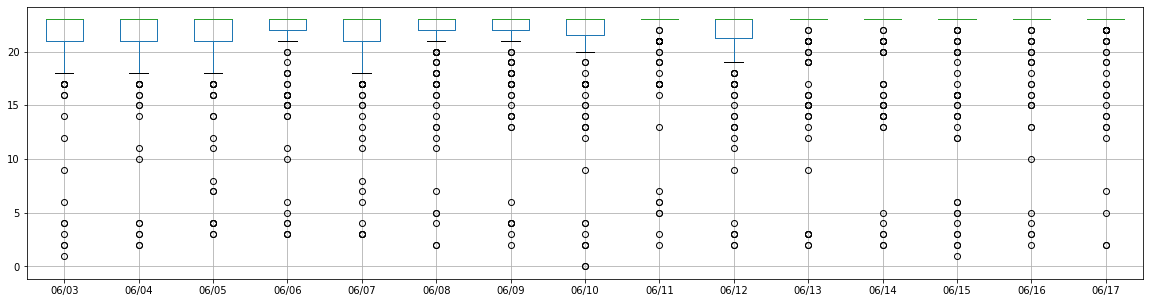

In [172]:
cap_hour_by_date_campaign = df_capping.pivot_table(values = 'cap_hour', index = 'ssb_campaign_uuid', columns = 'date', aggfunc = 'max')
cap_hour_by_date_campaign.columns = cap_hour_by_date_campaign.columns.astype('datetime64[ns]')
fig, ax = plt.subplots(figsize = (20,5))
cap_hour_by_date_campaign.boxplot(ax=ax)
plt.xticks(np.arange(cap_hour_by_date_campaign.shape[1])[::1]+1, cap_hour_by_date_campaign.columns[::1].strftime('%m/%d'))


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without 

[(0.0, 30.0)]

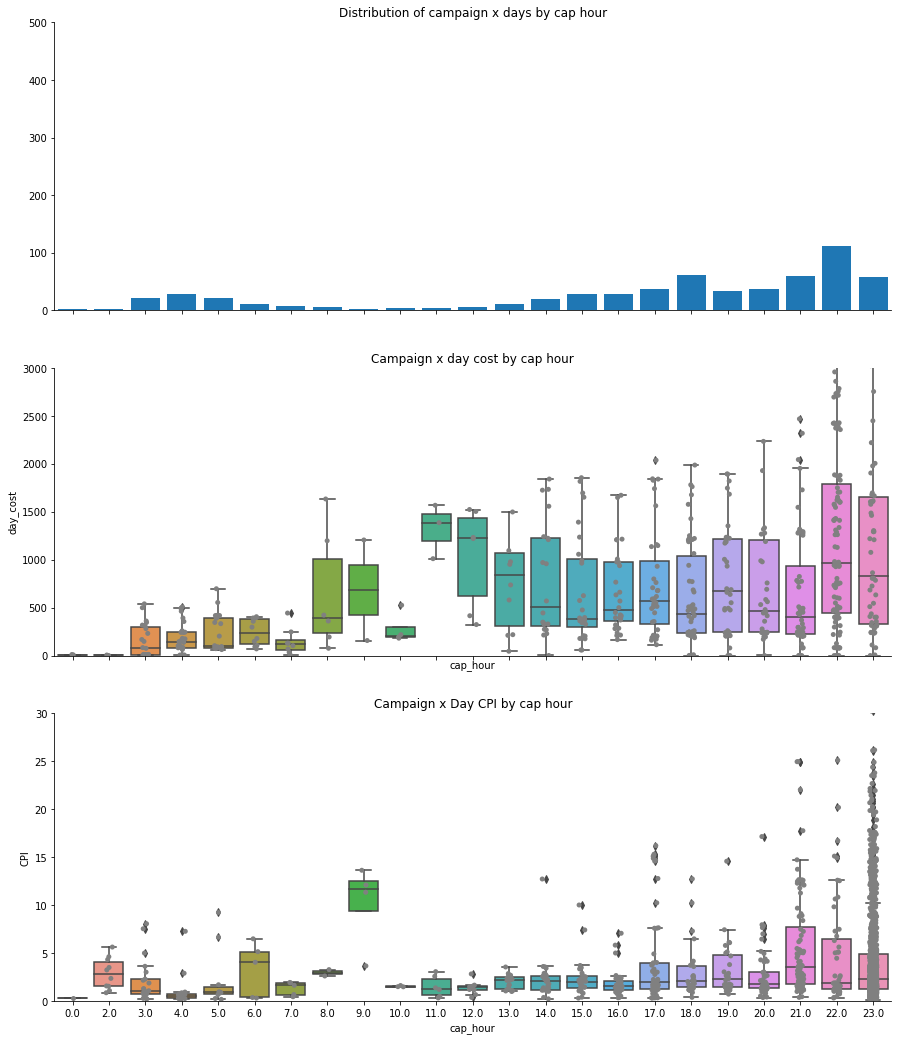

In [173]:
df_capping['day_spend'] = df_capping.groupby(['ssb_campaign_uuid','date'])['spend'].transform('sum')
df_capping['day_cost'] = df_capping.groupby(['ssb_campaign_uuid','date'])['cost'].transform('sum')
df_capping['day_installs'] = df_capping.groupby(['ssb_campaign_uuid','date'])['installs'].transform('sum')

cap_hour_by_campaign_date = df_capping[df_capping.day_cost > 0].pivot_table(values = ['cap_hour','day_cost','day_installs'], index = ['ssb_campaign_uuid','date'], aggfunc = 'mean').reset_index()
cap_hour_counts = cap_hour_by_campaign_date.pivot_table(values = ['ssb_campaign_uuid','day_cost'], index = ['cap_hour'], aggfunc = {'ssb_campaign_uuid':'count', 'day_cost':'mean'})
cap_hour_by_campaign_date['CPI'] = cap_hour_by_campaign_date['day_cost']/cap_hour_by_campaign_date['day_installs']

fig, ax = plt.subplots(3,1, figsize = (15,18), sharex = True)
ax[0].bar(cap_hour_counts.index, cap_hour_counts['ssb_campaign_uuid'])
ax[0].set_title('Distribution of campaign x days by cap hour')
ax[0].set_ylim(0,500)
ax[1].set_title('Campaign x day cost by cap hour')
sns.stripplot('cap_hour', 'day_cost', data = cap_hour_by_campaign_date, ax = ax[1], color = 'grey')
sns.boxplot('cap_hour', 'day_cost', data = cap_hour_by_campaign_date, ax = ax[1])
ax[1].set(ylim = (0,3000))

cap_hour_by_campaign_date = cap_hour_by_campaign_date.loc[cap_hour_by_campaign_date.day_installs > 0]
ax[2].set_title('Campaign x Day CPI by cap hour')
sns.stripplot('cap_hour', 'CPI', data = cap_hour_by_campaign_date, ax = ax[2], color = 'grey')
sns.boxplot('cap_hour', 'CPI', data = cap_hour_by_campaign_date, ax = ax[2])
sns.despine()
ax[2].set(ylim = (0,30))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without 

[(0.0, 30.0)]

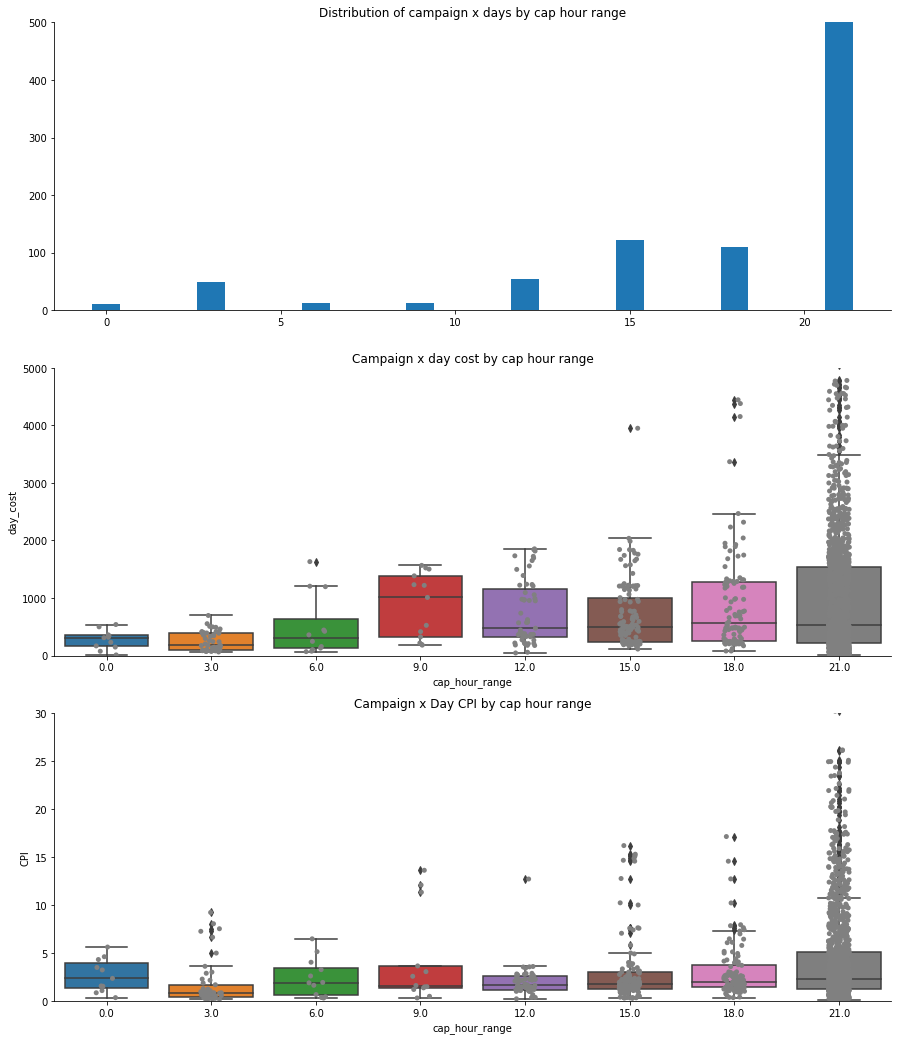

In [174]:
cap_hour_by_campaign_date['cap_hour_range'] = 3*np.floor(cap_hour_by_campaign_date['cap_hour']/3)

cap_hour_counts = cap_hour_by_campaign_date.pivot_table(values = ['ssb_campaign_uuid','day_cost'], index = ['cap_hour_range'], aggfunc = {'ssb_campaign_uuid':'count', 'day_cost':'mean'})
cap_hour_by_campaign_date['CPI'] = cap_hour_by_campaign_date['day_cost']/cap_hour_by_campaign_date['day_installs']

fig, ax = plt.subplots(3,1, figsize = (15,18))
ax[0].bar(cap_hour_counts.index, cap_hour_counts['ssb_campaign_uuid'])
ax[0].set_title('Distribution of campaign x days by cap hour range')
ax[0].set_ylim(0,500)
ax[1].set_title('Campaign x day cost by cap hour range')
sns.stripplot('cap_hour_range', 'day_cost', data = cap_hour_by_campaign_date, ax = ax[1], color = 'grey')
sns.boxplot('cap_hour_range', 'day_cost', data = cap_hour_by_campaign_date, ax = ax[1])
ax[1].set(ylim = (0,5000))

cap_hour_by_campaign_date = cap_hour_by_campaign_date.loc[cap_hour_by_campaign_date.day_installs > 0]
ax[2].set_title('Campaign x Day CPI by cap hour range')
sns.stripplot('cap_hour_range', 'CPI', data = cap_hour_by_campaign_date, ax = ax[2], color = 'grey')
sns.boxplot('cap_hour_range', 'CPI', data = cap_hour_by_campaign_date, ax = ax[2])
sns.despine()
ax[2].set(ylim = (0,30))

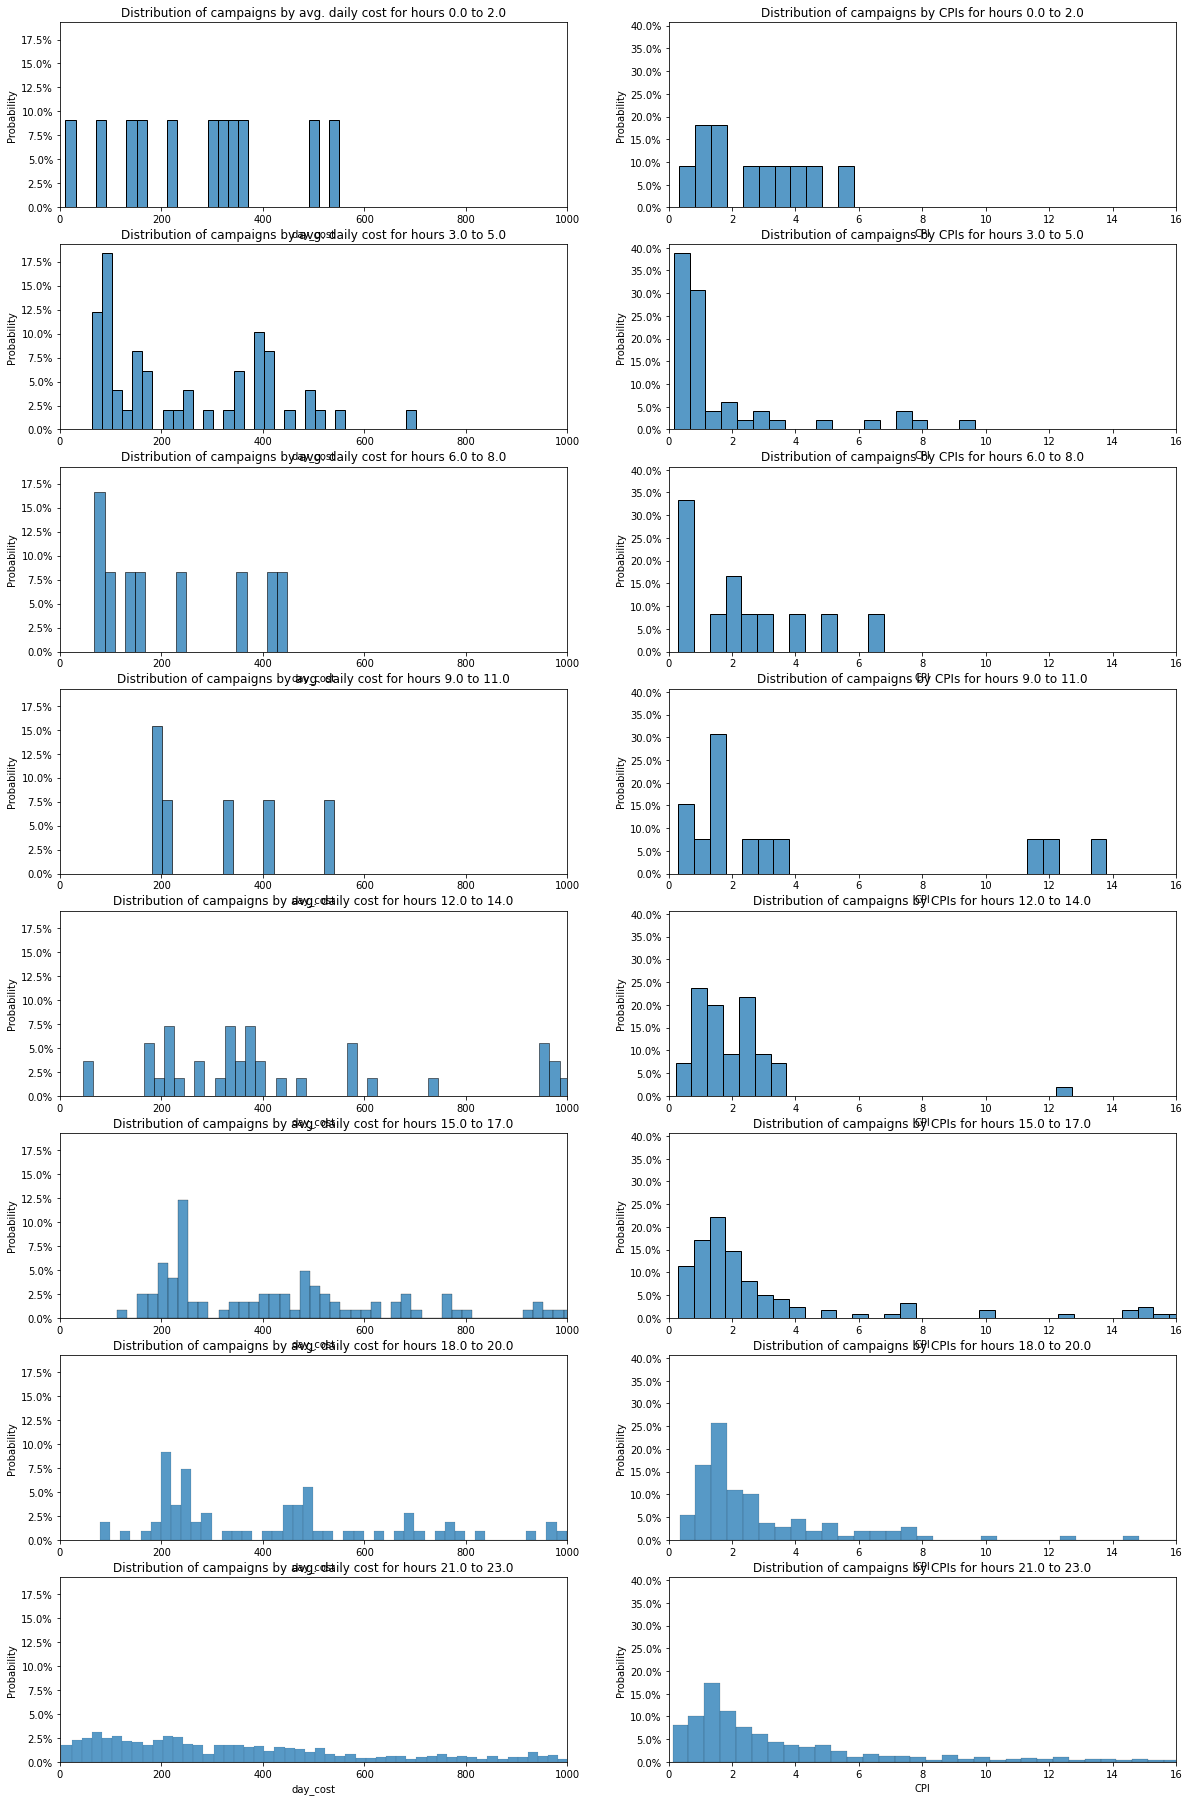

In [175]:
cap_hour_range_list = cap_hour_by_campaign_date.cap_hour_range.sort_values().unique().tolist()

# ax = sns.displot(cap_hour_by_campaign_date.loc[cap_hour_by_campaign_date.cap_hour_range < 24], x="day_cost", hue="cap_hour_range", kind="kde")
# ax.set(ylim=(0, .0001))

fig, ax = plt.subplots(len(cap_hour_range_list),2, figsize = (20, 4*len(cap_hour_range_list)), sharey = 'col')

for c in cap_hour_range_list:
    hist_data = cap_hour_by_campaign_date.loc[(cap_hour_by_campaign_date.cap_hour_range == c) & (cap_hour_by_campaign_date.day_installs > 0)]
    n = cap_hour_range_list.index(c)
    sns.histplot(x = 'day_cost', data = hist_data, ax = ax[n,0], binwidth = 20, stat = 'probability')
    ax[n,0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax[n,0].set_title(f'Distribution of campaigns by avg. daily cost for hours {c} to {c+2}')
    ax[n,0].set_xlim(0,1000)
    sns.histplot(x = 'CPI', data = hist_data, ax = ax[n,1], binwidth = .5, stat = 'probability')
    ax[n,1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax[n,1].set_xlim(0,16)
    ax[n,1].set_title(f'Distribution of campaigns by CPIs for hours {c} to {c+2}')
    


In [176]:
cap_hour_limit = 18
days_capped = 3

cap_hour_by_campaign_date_dt = df_capping[(df_capping.day_spend > 0) & (df_capping.buyer == 'DT')].pivot_table(values = ['cap_hour','day_spend','day_cost','day_installs'], index = ['ssb_campaign_uuid','date'], aggfunc = 'mean').reset_index()
capping_campaigns = cap_hour_by_campaign_date_dt.pivot_table(values = ['cap_hour','day_spend', 'day_cost','day_installs'], index = 'ssb_campaign_uuid', aggfunc = {'cap_hour':lambda x:sum(x < cap_hour_limit), 'day_spend':sum, 'day_cost':sum,'day_installs':sum})
capping_campaigns.columns = [f'days_capped_pre_hr{cap_hour_limit}', 'cost','installs', 'spend']
capping_campaigns['cpi'] = capping_campaigns['spend']/capping_campaigns['installs']
top_capping_campaigns = capping_campaigns[capping_campaigns[f'days_capped_pre_hr{cap_hour_limit}']> days_capped].sort_values('spend', ascending = False).index[:20]

capping_campaigns[capping_campaigns[f'days_capped_pre_hr{cap_hour_limit}'] > days_capped].sort_values('spend', ascending = False).head(30)


days_capped_pre_hr18          cost  \
ssb_campaign_uuid                                                      
460c77fda3ba6cdf651311f5eedb7187                  13.0  25339.656224   
5d294c23d51b0c64a63275f4b8412067                  10.0  26070.214706   
292906bbb71deaebb880439ce8c72995                  10.0  27232.324120   
972ab77915d0c7999b39c953c028405d                   6.0  10240.660677   
545149fc54f7c1283d6c0c90ab8ce7e2                  12.0  14842.133618   
b8ccac17c71b8482cc92647a94577a57                   7.0  11782.797761   
949d2cb0616d95548bf7a4010a611373                   4.0  11487.590869   
056de71a36a786a3fdc5e53a0b59945f                  13.0   3852.975578   
099a5d47e9bf3796c1b9ca5c5f4bc264                  12.0  18553.694452   
1571beff3a29fb6c338d022f4c47dad1                  13.0   4340.947483   
7202dbf7eba49491175e9c2b0cb5bb93                   6.0   7288.000580   
d8ee55bb6a1ac49f92211ed4a9313f85                  11.0   6183.586929   
0282f78e216dfd3118d71a5fe5ff49bf                   9.0   9816.220451   
d71c42106c0bce1ab4ec672121dfe9a6                  15.0   3247.264274   
e5e0b9aaf5a2e9d3dc197f9c0ea04c12                  15.0   5695.416791   
e667256b49c75577c5632ec85ab6a16a                  14.0   8888.490772   
1c27258e207d6b9c665a7f42e6a3a258                  11.0   5135.009609   
61b31cd4b6d33e1191aa798d27d5ae63                   8.0   3043.650158   
a08c839bf3d7a5cae94eeabf45e081a4                  15.0   1225.413137   
c40b9831f92edcadd201041150f92c5e                  12.0   3121.981431   
f994d8435219ca26a528eb5f9f6545a6                   9.0   4658.024910   
36ae7ad338ae30c3eb64019727173e8a                   8.0   2258.450682   
5710e8d0bbf97a40aa5e09b8649f546f                   6.0   4440.957139   

                                  installs    spend        cpi  
ssb_campaign_uuid                                               
460c77fda3ba6cdf651311f5eedb7187     20032  34054.4   1.700000  
5d294c23d51b0c64a63275f4b8412067     14688  33048.0   2.250000  
292906bbb71deaebb880439ce8c72995     18784  32336.0   1.721465  
972ab77915d0c7999b39c953c028405d      6000  30000.0   5.000000  
545149fc54f7c1283d6c0c90ab8ce7e2     11344  19156.8   1.688717  
b8ccac17c71b8482cc92647a94577a57      4992  14976.0   3.000000  
949d2cb0616d95548bf7a4010a611373      7616  14128.0   1.855042  
056de71a36a786a3fdc5e53a0b59945f      1328  13280.0  10.000000  
099a5d47e9bf3796c1b9ca5c5f4bc264      7360  12512.0   1.700000  
1571beff3a29fb6c338d022f4c47dad1      4080  12240.0   3.000000  
7202dbf7eba49491175e9c2b0cb5bb93      4704  11760.0   2.500000  
d8ee55bb6a1ac49f92211ed4a9313f85      2224  11120.0   5.000000  
0282f78e216dfd3118d71a5fe5ff49bf      3840  10499.2   2.734167  
d71c42106c0bce1ab4ec672121dfe9a6      9360   9360.0   1.000000  
e5e0b9aaf5a2e9d3dc197f9c0ea04c12      8192   8192.0   1.000000  
e667256b49c75577c5632ec85ab6a16a      8176   8176.0   1.000000  
1c27258e207d6b9c665a7f42e6a3a258      2224   4448.0   2.000000  
61b31cd4b6d33e1191aa798d27d5ae63       400   4000.0  10.000000  
a08c839bf3d7a5cae94eeabf45e081a4      4592   3028.8   0.659582  
c40b9831f92edcadd201041150f92c5e      1232   2772.0   2.250000  
f994d8435219ca26a528eb5f9f6545a6      1056   2704.0   2.560606  
36ae7ad338ae30c3eb64019727173e8a       496   2480.0   5.000000  
5710e8d0bbf97a40aa5e09b8649f546f       592   2368.0   4.000000

In [177]:
agg_dict = {'impressions': sum
           ,'installs':sum
           ,'spend':sum
           ,'cost':sum
           ,'cap_hour':max
           ,'day_cost':max
           }

campaign_by_hour = df_capping.pivot_table(values = ['impressions','installs','spend','cost','cap_hour','day_cost'], index = ['ssb_campaign_uuid','date','hour'], aggfunc = agg_dict).reset_index()
campaign_by_hour['cpi'] = campaign_by_hour['spend']/campaign_by_hour['installs']
campaign_by_hour[(campaign_by_hour.ssb_campaign_uuid.isin([top_capping_campaigns[0]])) & (campaign_by_hour.cap_hour < cap_hour_limit)].head(30)


ssb_campaign_uuid       date  hour  cap_hour  \
14490  460c77fda3ba6cdf651311f5eedb7187 2021-06-04     1      14.0   
14491  460c77fda3ba6cdf651311f5eedb7187 2021-06-04     2      14.0   
14492  460c77fda3ba6cdf651311f5eedb7187 2021-06-04     3      14.0   
14493  460c77fda3ba6cdf651311f5eedb7187 2021-06-04     4      14.0   
14494  460c77fda3ba6cdf651311f5eedb7187 2021-06-04     5      14.0   
14495  460c77fda3ba6cdf651311f5eedb7187 2021-06-04     6      14.0   
14496  460c77fda3ba6cdf651311f5eedb7187 2021-06-04     7      14.0   
14497  460c77fda3ba6cdf651311f5eedb7187 2021-06-04     8      14.0   
14498  460c77fda3ba6cdf651311f5eedb7187 2021-06-04     9      14.0   
14499  460c77fda3ba6cdf651311f5eedb7187 2021-06-04    10      14.0   
14500  460c77fda3ba6cdf651311f5eedb7187 2021-06-04    11      14.0   
14501  460c77fda3ba6cdf651311f5eedb7187 2021-06-04    12      14.0   
14502  460c77fda3ba6cdf651311f5eedb7187 2021-06-04    13      14.0   
14503  460c77fda3ba6cdf651311f5eedb7187 2021-06-04    14      14.0   
14504  460c77fda3ba6cdf651311f5eedb7187 2021-06-05     1      12.0   
14505  460c77fda3ba6cdf651311f5eedb7187 2021-06-05     2      12.0   
14506  460c77fda3ba6cdf651311f5eedb7187 2021-06-05     3      12.0   
14507  460c77fda3ba6cdf651311f5eedb7187 2021-06-05     4      12.0   
14508  460c77fda3ba6cdf651311f5eedb7187 2021-06-05     5      12.0   
14509  460c77fda3ba6cdf651311f5eedb7187 2021-06-05     6      12.0   
14510  460c77fda3ba6cdf651311f5eedb7187 2021-06-05     7      12.0   
14511  460c77fda3ba6cdf651311f5eedb7187 2021-06-05     8      12.0   
14512  460c77fda3ba6cdf651311f5eedb7187 2021-06-05     9      12.0   
14513  460c77fda3ba6cdf651311f5eedb7187 2021-06-05    10      12.0   
14514  460c77fda3ba6cdf651311f5eedb7187 2021-06-05    11      12.0   
14515  460c77fda3ba6cdf651311f5eedb7187 2021-06-05    12      12.0   
14516  460c77fda3ba6cdf651311f5eedb7187 2021-06-06     1      11.0   
14517  460c77fda3ba6cdf651311f5eedb7187 2021-06-06     2      11.0   
14518  460c77fda3ba6cdf651311f5eedb7187 2021-06-06     3      11.0   
14519  460c77fda3ba6cdf651311f5eedb7187 2021-06-06     4      11.0   

             cost     day_cost  impressions  installs  spend  cpi  
14490   96.545514  1390.676752        13376        96  163.2  1.7  
14491  251.870838  1390.676752        30224       240  408.0  1.7  
14492  192.224633  1390.676752        24320       240  408.0  1.7  
14493  134.277196  1390.676752        15168       160  272.0  1.7  
14494   84.306445  1390.676752        10560        64  108.8  1.7  
14495   60.053068  1390.676752         6432        32   54.4  1.7  
14496   31.788531  1390.676752         4000        16   27.2  1.7  
14497   31.486457  1390.676752         3888        32   54.4  1.7  
14498   54.712577  1390.676752         5536        80  136.0  1.7  
14499   71.329486  1390.676752         7024        64  108.8  1.7  
14500  103.586329  1390.676752        10848        32   54.4  1.7  
14501  120.536736  1390.676752        11904       128  217.6  1.7  
14502  141.667012  1390.676752        14144        96  163.2  1.7  
14503   16.291932  1390.676752         1504         0    0.0  NaN  
14504  136.463455  1496.716766        13664        80  136.0  1.7  
14505  364.850552  1496.716766        34816       208  353.6  1.7  
14506  272.556259  1496.716766        25728       240  408.0  1.7  
14507  225.655615  1496.716766        19168        64  108.8  1.7  
14508  114.608165  1496.716766        11456       128  217.6  1.7  
14509   69.518360  1496.716766         7920        64  108.8  1.7  
14510   36.717050  1496.716766         4240         0    0.0  NaN  
14511   29.594701  1496.716766         3168        48   81.6  1.7  
14512   42.093059  1496.716766         4720        32   54.4  1.7  
14513   67.121162  1496.716766         6112        16   27.2  1.7  
14514   92.418324  1496.716766         9744        32   54.4  1.7  
14515   45.120064  1496.716766         4672        96  163.2  1.7  
14516  195.9851

In [178]:
top_campaigns = df_capping.groupby('ssb_campaign_uuid').sum().sort_values('spend', ascending = False).head(20).index.to_list()
df_capping_offset = pd.merge(df_capping, tz_bycountry, how = 'left', left_on = 'country', right_on = 'Country Code')
df_capping_offset['hour_local'] = round(df_capping_offset.hour + df_capping_offset.offset_hrs.astype('int', errors = 'ignore'),0).astype(int, errors = 'ignore')
df_capping_offset.loc[df_capping_offset.hour_local > 23, 'hour_local'] = df_capping_offset['hour_local'] - 24
df_capping_offset.loc[df_capping_offset.hour_local < 0, 'hour_local'] = df_capping_offset['hour_local'] + 24

NameError: name 'campaigns' is not defined

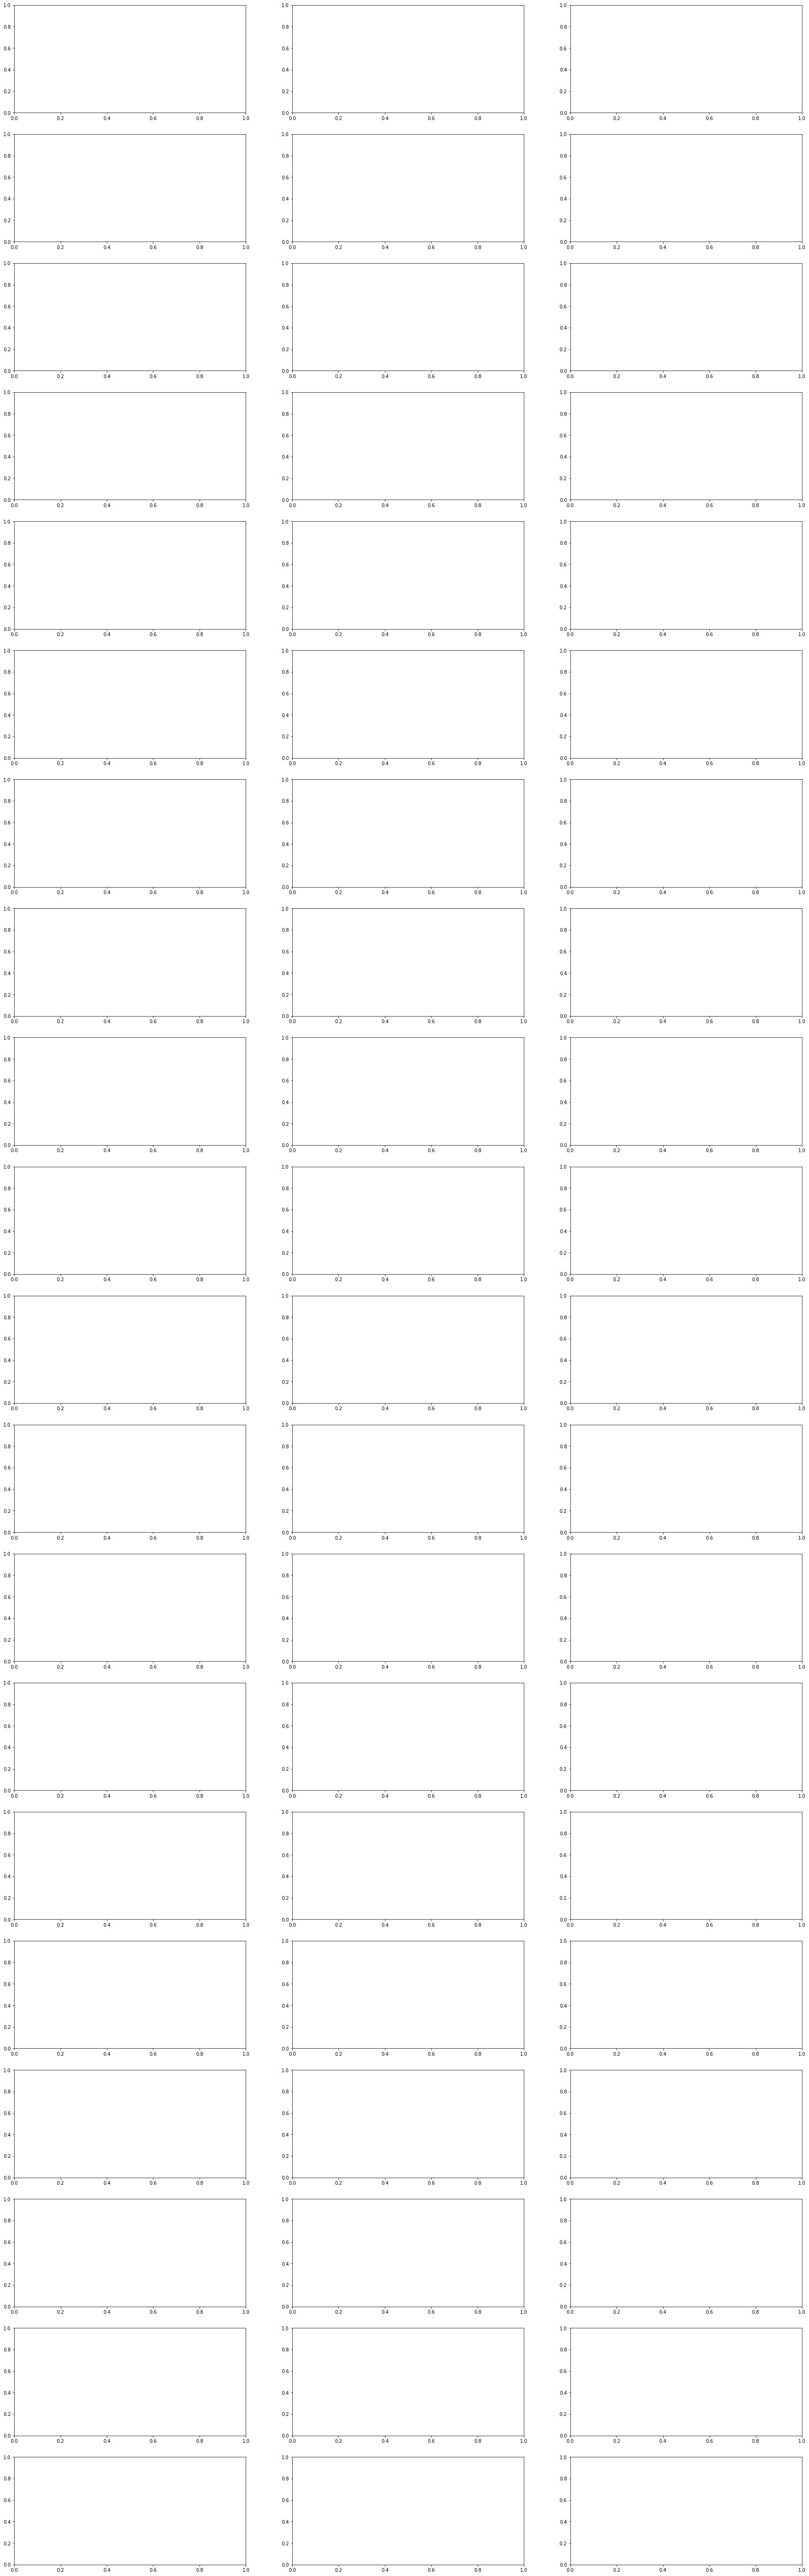

In [179]:
fig, ax = plt.subplots(len(top_campaigns),3, figsize = (30,5*len(top_campaigns)))

for n in range(len(top_campaigns)):
    cmp_id = top_campaigns[n]
    cmp_name = campaigns.loc[campaigns.index == cmp_id, 'name'].values
    if cmp_name.size == 0:
        cmp_name = cmp_id
    pvt = df_capping_offset[df_capping_offset.ssb_campaign_uuid == cmp_id].pivot_table(values = ['impressions','installs','spend','cost'], index = 'hour_local', aggfunc = 'mean')
    pvt['cpm'] = 1000*pvt['cost']/pvt['impressions']

    ax[n,0].plot(pvt[['spend','cost']])
    ax[n,0].set_title(f'spend/cost by (local) hour of day - {cmp_name}')
    ax[n,0].legend(['spend','cost'])
    ax[n,1].plot(pvt[['installs']])
    ax[n,1].set_title(f'installs by (local) hour of day - {cmp_name}')
    ax[n,2].plot(pvt[['cpm']])
    ax[n,2].set_title(f'cpm by (local) hour of day - {cmp_name}')

(0.0, 10.0)

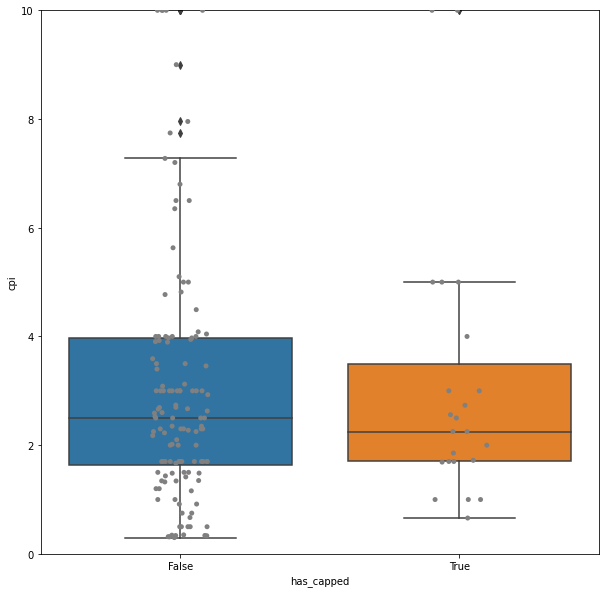

In [180]:
capping_campaigns['top_capping_campaign'] = capping_campaigns.index.isin(top_capping_campaigns)
stripplot_data = capping_campaigns.sort_values('spend', ascending = False).head(1000).reset_index()
stripplot_data['has_capped'] = stripplot_data[f'days_capped_pre_hr{cap_hour_limit}'] > days_capped
fig, ax = plt.subplots(figsize = (10,10))
sns.stripplot(x = 'has_capped', y = 'cpi', data = stripplot_data, color = 'grey')
sns.boxplot(x = 'has_capped', y = 'cpi', data = stripplot_data)
ax.set_ylim(0,10)

(6) Which Campaigns are budget capping?

(7) % of Budget left

(8) Is the issue Auto-Pilot or ML Models

(9) Are we hitting tCPI or not?

In [192]:
df_capping['early_cap'] = df_capping.cap_hour <= 20
pivot = df_capping.pivot_table(values = 'date', index = 'name', columns = 'early_cap', aggfunc = lambda x:len(x.unique()), margins = True)
pivot['early_cap_pct'] = 100*pivot[True]/pivot['All']
pivot = pivot.fillna(0)
pivot.sort_values(True, ascending = False, inplace = True)

format_map = {False:'{:.0f}'
             ,True:'{:.0f}'
             ,'All':'{:.0f}'
             ,'early_cap_pct':'{:.0f}%'}
pivot.iloc[1:].head(50).style.format(format_map).background_gradient(cmap=cm, subset = ['early_cap_pct'])

In [255]:
pivot = df_capping.pivot_table(values = ['date','cap_hour'], index = 'name', columns = 'early_cap', aggfunc = {'date':lambda x:len(x.unique()),'cap_hour':np.mean}, margins = True)
pivot.sort_values(('date',True), ascending = False, inplace = True)
pivot['early_cap_pct'] = 100*pivot[('date',True)]/pivot[('date','All')]
format_map = {('cap_hour',False):'{:.0f}'
             ,('cap_hour',True):'{:.0f}'
             ,('cap_hour','All'):'{:.0f}'
             ,('date',False):'{:.0f}'
             ,('date',True):'{:.0f}'
             ,('date','All'):'{:.0f}'
             ,('early_cap_pct',''):'{:.0f}%'}
pivot.iloc[1:].head(50).style.format(format_map).background_gradient(cmap=cm, subset = [('cap_hour',True), ('early_cap_pct','')])


In [251]:
df_capping[df_capping.name == 'Android-Klarna-Klarna-US-2'].pivot_table(values = ['impressions','cost'], index = ['date','hour'], aggfunc=np.sum).tail(30)


cost  impressions
date       hour                        
2021-06-03 1     54.135003        36656
           2     28.487329        18640
2021-06-04 2     60.006816        49632
           4     13.819161         9744
2021-06-05 1     39.655497        28752
           2     21.817541        17280
           4     18.056234        13696
2021-06-06 2     51.934970        45152
           3     11.327682        10160
2021-06-07 2     64.434507        52304
           3      7.882374         2992
2021-06-08 2     21.857389        17120
           3     51.410583        33872
           4     29.554283        14896
2021-06-09 2     61.860531        54784
           4     10.021012         9728

In [194]:
df_campaigns = bigquery_client.query(f"""
select
    name as campaign_name
    , *
from metadata.dt_campaigns c
""").to_dataframe()

In [195]:
json_struct = df_campaigns['extra_data'].apply(json.loads)
df_campaigns_flat = pd.io.json.json_normalize(json_struct) 
df_campaigns_joined = df_campaigns.join(df_campaigns_flat)
df_campaigns_joined.drop(['extra_data'], axis = 1, inplace = True)
df_campaigns_joined.rename(columns = {'uuid':'ssb_campaign_uuid'}, inplace = True)
df_campaigns_joined.columns[:50]

<ipython-input-195-a694b989169d>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_campaigns_flat = pd.io.json.json_normalize(json_struct)


Index(['campaign_name', 'updated_at', 'name', 'created_at', 'end_at',
       'ssb_campaign_uuid', 'country', 'form_factor', 'vertical_tag', 'status',
       'sponsored_app_id', 'platform', 'enabled', 'offer_id', 'start_at', 'id',
       'max_views', 'custom_revenue', 'ip_ranges', 'scan_restarted_at',
       'fcap_min_impressions_interval', 'fcap_consecutive_impressions',
       'realloc_scan_budget', 'auto_pilot', 'auto_pilot_level',
       'media_plan_daily_budget', 'reject_no_consent', 'use_dlp',
       'block_coppa', 'show_for_converted', 'bundle_retarget', 'ifa_presence',
       'use_external_browser', 'model_optimize', 'boost_enabled',
       'connectivity', 'maxmind_mask', 'media_plan_pacing_mode',
       'media_scan_pacing_mode', 'impression_attribution_enabled',
       'override_auto_actions', 'boost_max_multiplier',
       'override_account_blacklists', 'viewability_mode',
       'add_click_on_video_complete', 'smart_dnt', 'dnt_cap_boost',
       'creatives_ab_enabled', 'skad_

In [249]:
pivot2 = pivot.join(df_campaigns_joined.set_index('name'))[[False, True, 'All', 'early_cap_pct', 'media_plan_daily_budget']]
pivot2.sort_values('media_plan_daily_budget', ascending = False, inplace = True)
format_map = {False:'{:.0f}'
             ,True:'{:.0f}'
             ,'All':'{:.0f}'
             ,'media_plan_daily_budget':'${:,.0f}'
             ,'early_cap_pct':'{:.0f}%'}
pivot2[pivot2[True] > 5].head(50).style.format(format_map).background_gradient(cmap=cm, subset = ['early_cap_pct'])

KeyError: "[False, True, 'early_cap_pct', 'All'] not in index"

In [258]:
pivot = df_capping.pivot_table(values = ['date','day_cost'], index = 'name', columns = 'early_cap', aggfunc = {'date':lambda x:len(x.unique()), 'day_cost':'mean'}, margins = True)
pivot = pivot.join(df_campaigns_joined.set_index('name'))
pivot['early_cap_pct'] = 100*pivot[('date',True)]/pivot[('date','All')]
pivot = pivot.loc[:,pivot.columns[:6].tolist() + pivot.columns[-1:].tolist() + pivot.columns[30:31].tolist()]

pivot['not_early_cap_fill'] =100* pivot[('day_cost',False)]/pivot['media_plan_daily_budget']
pivot['early_cap_fill'] =100* pivot[('day_cost',True)]/pivot['media_plan_daily_budget']
pivot['avg_fill'] = 100*pivot[('day_cost','All')]/pivot['media_plan_daily_budget']
pivot.sort_values('media_plan_daily_budget', ascending = False, inplace = True)

format_map = {('date',False):'{:.0f}'
             ,('date',True):'{:.0f}'
             ,('date','All'):'{:.0f}'
             ,('day_cost',False):'${:,.0f}'
             ,('day_cost',True):'${:,.0f}'
             ,('day_cost','All'):'${:,.0f}'
             ,'media_plan_daily_budget':'${:,.0f}'
             ,'early_cap_pct':'{:.0f}%'
             ,'not_early_cap_fill':'{:.0f}%'
             ,'early_cap_fill':'{:.0f}%'
             ,'avg_fill':'{:.0f}%'}
pivot[pivot[('date',True)]>5].head(30).style.format(format_map).background_gradient(cmap=cm, subset = ['early_cap_pct','not_early_cap_fill','early_cap_fill','avg_fill'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/Users/daniel.ryu/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [281]:
pivot = df_capping.pivot_table(values = ['date','day_cost'], index = 'name', columns = ['early_cap','bidder'], aggfunc = {'date':lambda x:len(x.unique()), 'day_cost':'mean'}, margins = True)
pivot = pivot.fillna(0)
# pivot['not_early_cap_fill'] =100* pivot[('day_cost',False)]/pivot['media_plan_daily_budget']
# pivot['early_cap_fill'] =100* pivot[('day_cost',True)]/pivot['media_plan_daily_budget']
# pivot['avg_fill'] = 100*pivot[('day_cost','All')]/pivot['media_plan_daily_budget']
pivot.sort_values(('day_cost','All'), ascending = False, inplace = True)


cols = pivot.columns.tolist()[0:10] 

pivot = pivot.loc[((pivot[('date',True,'AutoPilot')])>2) & (pivot.index != 'All')]#,cols]

format_map = {('date',False,'AutoPilot'):'{:,.0f}'
             ,('date',True,'AutoPilot'):'{:,.0f}'
             ,('date',False,'ML'):'{:,.0f}'
             ,('date',True,'ML'):'{:,.0f}'
             ,('date','All',''):'{:,.0f}'
              ,('day_cost',False,'AutoPilot'):'${:,.0f}'
             ,('day_cost',True,'AutoPilot'):'${:,.0f}'
             ,('day_cost',False,'ML'):'${:,.0f}'
             ,('day_cost',True,'ML'):'${:,.0f}'
             ,('day_cost','All',''):'${:,.0f}'}
pivot.style.format(format_map).background_gradient(cmap=cm, subset = [('date',True, 'AutoPilot'),('date',True, 'ML')])

In [286]:
pivot = df_capping.pivot_table(values = ['date','cap_hour'], index = 'name', columns = ['bidder','early_cap'], aggfunc = {'date':lambda x:len(x.unique()),'cap_hour':np.mean}, margins = True)
pivot.sort_values(('date','AutoPilot',True), ascending = False, inplace = True)

format_map = {('cap_hour','ML',False):'{:.0f}'
             ,('cap_hour','ML',True):'{:.0f}'
             ,('date','ML',False):'{:.0f}'
             ,('date','ML',True):'{:.0f}'
              ,('cap_hour','AutoPilot',False):'{:.0f}'
             ,('cap_hour','AutoPilot',True):'{:.0f}'
             ,('cap_hour','All',''):'{:.0f}'
             ,('date','AutoPilot',False):'{:.0f}'
             ,('date','AutoPilot',True):'{:.0f}'
             ,('date','All',''):'{:.0f}'}
pivot.iloc[1:].head(50).style.format(format_map).background_gradient(cmap=cm, subset = [('cap_hour','ML',True), ('cap_hour','AutoPilot',True)])


Looks like between Autopilot vs ML, the early capping campaigns seem to have a pretty even split within each campaign for the early capping days.

In [203]:
df_offers = bigquery_client.query(f"""
select
    o.*
    , c.uuid
from metadata.dt_offers o
join metadata.dt_campaigns c
    on o.id = c.id
""").to_dataframe()
json_struct = df_offers['extra_data'].apply(json.loads)
df_offers_flat = pd.io.json.json_normalize(json_struct) 
df_offers_joined = df_offers.join(df_offers_flat)
df_offers_joined.drop(['extra_data'], axis = 1, inplace = True)
df_offers_joined.rename(columns = {'uuid':'ssb_campaign_uuid'}, inplace = True)
df_offers_joined.iloc[1]

<ipython-input-203-c4f36a6ad769>:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_offers_flat = pd.io.json.json_normalize(json_struct)


package_name                                                            com.pandora.android
user_defined_type                                                               app install
type                                                                            OfferCustom
affiliate_network                                                                      None
cpi                                                                                     0.0
updated_at                                                        2021-04-28 23:09:47+00:00
form_factor                                                                              10
country                                                                                  US
status                                                                                   up
platform                                                                                  1
name                                      Pandora - Pandora - US - Cold - Retarg

In [290]:
df_capping_offer = df_capping.set_index(['ssb_campaign_uuid','country']).join(df_offers_joined.set_index((['ssb_campaign_uuid','country'])), how = 'left', rsuffix = ('_offers'))
df_capping_offer.isna().sum()

name                                          0
buyer                                         0
bidder                                        0
date                                          0
dow                                           0
                                          ...  
auto_pilot_cpa_factor                     72418
geoedge_excluded_trigger_types            68400
reject_data                               68400
optimization_action_revenue_goal_perct    72778
custom_categories                         72778
Length: 261, dtype: int64

In [328]:
df_capping_offer['cpi_new'] = df_capping_offer.apply(lambda x:(x['cpi']*x['auto_pilot_cpa_factor'] if x['auto_pilot_cpa_factor']!=1 else x['cpi']), axis =1)
df_capping_offer[['cpi','auto_pilot_cpa_factor','cpi_new']].drop_duplicates()

cpi  auto_pilot_cpa_factor  \
ssb_campaign_uuid                country                                 
0282f78e216dfd3118d71a5fe5ff49bf TR         NaN                    NaN   
056de71a36a786a3fdc5e53a0b59945f US        2.00                    NaN   
06999d835967801342ac5e0138b30d6b US        1.50                    NaN   
0e9c2325d441a0d3b979cb7858afac99 US        3.50                    NaN   
1571beff3a29fb6c338d022f4c47dad1 US        1.25                    NaN   
1c27258e207d6b9c665a7f42e6a3a258 US        8.00                    NaN   
1cf20a765c40489fbb3587b56117bda9 US        2.50                    NaN   
210ac4f3f71f72626918718eaec60cea US        3.00                    NaN   
2359e9439151f256228cedd5f8780ed4 US        0.85                    NaN   
237771ab834d300727c842cadac8d617 BR        0.50                    NaN   
2da0b609215635e899c59e7a302a2f28 US        1.70                    NaN   
2dd2a824567d92d80db998336d8c43d6 US        2.30                    NaN   
377f69bc9e2d613ee60d07d1df5897d5 US        1.16                    NaN   
3d49799460091904856b1753e55330ba US       15.00                    NaN   
4c7f5d9964abdca5793b3d48f13fe6f9 US        5.00                    NaN   
5d294c23d51b0c64a63275f4b8412067 US        1.00                    NaN   
60afc4f294695ffe7ea525534f019d20 US        1.20                    NaN   
657257a6e7ad335005764c5829718695 US        2.35                    NaN   
6b30d761b933474e9bde645b1d95052c US        9.00                    NaN   
6e8c92368479165b5464224b5dc43075 US        0.70                    NaN   
7202dbf7eba49491175e9c2b0cb5bb93 US        4.00                    NaN   
729de681656730b0c02ebd707962aec0 BR        0.30                    NaN   
88d9d3f8ab16deb5dd8908b6cfa3278a US        1.67                    NaN   
8be9c44a77186c53f538e3344c487b4e US        2.25                    NaN   
cfbad4e5cdfcf8e68d0ff1ddb5135586 US        1.00                    2.0   
d3a92d5cb2d98df0faf1fe0c47478e21 US        1.09                    NaN   
f17cb3bd946540362a5d848a0779b915 US        6.00                    NaN   
f26adcfdd8b0a653e86528af46961c1d US        4.20                    NaN   

                                          cpi_new  
ssb_campaign_uuid                country           
0282f78e216dfd3118d71a5fe5ff49bf TR           NaN  
056de71a36a786a3fdc5e53a0b59945f US           NaN  
06999d835967801342ac5e0138b30d6b US           NaN  
0e9c2325d441a0d3b979cb7858afac99 US           NaN  
1571beff3a29fb6c338d022f4c47dad1 US           NaN  
1c27258e207d6b9c665a7f42e6a3a258 US           NaN  
1cf20a765c40489fbb3587b56117bda9 US           NaN  
210ac4f3f71f72626918718eaec60cea US           NaN  
2359e9439151f256228cedd5f8780ed4 US           NaN  
237771ab834d300727c842cadac8d617 BR           NaN  
2da0b609215635e899c59e7a302a2f28 US           NaN  
2dd2a824567d92d80db998336d8c43d6 US           NaN  
377f69bc9e2d613ee60d07d1df5897d5 US           NaN  
3d49799460091904856b1753e55330ba US           NaN  
4c7f5d9964abdca5793b3d48f13fe6f9 US           NaN  
5d294c23d51b0c64a63275f4b8412067 US           NaN  
60afc4f294695ffe7ea525534f019d20 US           NaN  
657257a6e7ad335005764c5829718695 US           NaN  
6b30d761b933474e9bde645b1d95052c US           NaN  
6e8c92368479165b5464224b5dc43075 US           NaN  
7202dbf7eba49491175e9c2b0cb5bb93 US           NaN  
729de681656730b0c02ebd707962aec0 BR           NaN  
88d9d3f8ab16deb5dd8908b6cfa3278a US           NaN  
8be9c44a77186c53f538e3344c487b4e US           NaN  
cfbad4e5cdfcf8e68d0ff1ddb5135586 US           2.0  
d3a92d5cb2d98df0faf1fe0c47478e21 US           NaN  
f17cb3bd946540362a5d848a0779b915 US           NaN  
f26adcfdd8b0a653e86528af46961c1d US           NaN

In [317]:

pivot = df_capping_offer.pivot_table(values = ['installs','spend','cap_hour','cpi_new']
                               , index = ['name','date']
                               , aggfunc = {'installs':sum,'spend':sum,'cap_hour':max, 'cpi_new':max})
pivot.columns = ['cap_hour','tCPI','installs','spend']
pivot['cpi'] = pivot['spend']/pivot['installs']
pivot['tCPI_missed'] = (round(pivot['cpi'],2) > round(pivot['tCPI'],2)) & (~pivot.tCPI.isna()) & (~pivot.cpi.isna())
pivot2 = pivot.reset_index().pivot_table(values = 'date', index = 'name', columns = 'tCPI_missed', aggfunc = 'count', margins = True)
pivot2.sort_values(True, ascending = False).iloc[1:30]

tCPI_missed                                         False  True  All
name                                                                
Credit Sesame - Credit Sesame - UA – US               NaN  15.0   15
King - Candy Crush - US - GP - Video                  NaN  15.0   15
Opera News - Opera News - US - UA ATT                 NaN  15.0   15
Opera News - Opera News - US - UA Cricket             NaN  15.0   15
Opera News - Opera News - US - UA USCC                NaN  15.0   15
Pandora - Pandora - US - PR                           NaN  15.0   15
Pandora - Pandora - US - True GP                      NaN  15.0   15
Pandora - Pandora - US - UA                           NaN  15.0   15
Particle Media - News Break - US - ATT UA             NaN  15.0   15
Particle Media - News Break - US - Tracfone UA        NaN  15.0   15
Particle Media - News Break - US - USCC PR            NaN  15.0   15
Particle Media - News Break - US - USCC UA            NaN  15.0   15
Particle Media - News Break - US - VZW PR - Dis...    NaN  15.0   15
Particle Media - News Break - US - VZW PR - Video     NaN  15.0   15
Particle Media - News Break - US - VZW UA             NaN  15.0   15
Particle Media – News Break – US – All – GP - D...    NaN  15.0   15
SingleTap-DSP-PlaySimple-Word Jam-US-T2               NaN  15.0   15
Twitter - Twitter - BR - True GP                      NaN  15.0   15
HMI - Popeyes - US - UA                               NaN  15.0   15
King - Candy Crush - US - UA - Video                  NaN  15.0   15
Blind Ferret - Rewarded Play - US - UA                NaN  15.0   15
Android-Wish-Wish-US-3                                NaN  15.0   15
Android-Wish-Wish-US-2                                NaN  15.0   15
Android-Rovio-Angry Birds Dream Blast-US-4            NaN  15.0   15
Android-King-Candy Crush-US-4-Video                   NaN  15.0   15
Playsimple-Word Jam-US-WL T1                          1.0  14.0   15
SingleTap_FB_ROW_Android_Video_FB_BR                  2.0  13.0   15
Android-Playtika-Slotomania-US-2                      NaN  13.0   13
Android-Playtika-SGH-US-2                             NaN  13.0   13

In [292]:
pivot[pivot.index.get_level_values(0) == 'HMI - Popeyes - US - UA']

cap_hour  tCPI  installs   spend   cpi  \
name                    date                                                 
HMI - Popeyes - US - UA 2021-06-03      23.0   1.5       592  1391.2  2.35   
                        2021-06-04      23.0   1.5       608  1428.8  2.35   
                        2021-06-05      23.0   1.5       576  1353.6  2.35   
                        2021-06-06      23.0   1.5       592  1391.2  2.35   
                        2021-06-07      23.0   1.5       624  1466.4  2.35   
                        2021-06-08      23.0   1.5       592  1391.2  2.35   
                        2021-06-09      23.0   1.5       688  1616.8  2.35   
                        2021-06-10      23.0   1.5       688  1616.8  2.35   
                        2021-06-11      23.0   1.5       592  1391.2  2.35   
                        2021-06-12      23.0   1.5       576  1353.6  2.35   
                        2021-06-13      23.0   1.5       464  1090.4  2.35   
                        2021-06-14      23.0   1.5       336   789.6  2.35   
                        2021-06-15      23.0   1.5        64   150.4  2.35   
                        2021-06-16      23.0   1.5       128   300.8  2.35   
                        2021-06-17      23.0   1.5       128   300.8  2.35   

                                    tCPI_missed  
name                    date                     
HMI - Popeyes - US - UA 2021-06-03         True  
                        2021-06-04         True  
                        2021-06-05         True  
                        2021-06-06         True  
                        2021-06-07         True  
                        2021-06-08         True  
                        2021-06-09         True  
                        2021-06-10         True  
                        2021-06-11         True  
                        2021-06-12         True  
                        2021-06-13         True  
                        2021-06-14         True  
                        2021-06-15         True  
                        2021-06-16         True  
                        2021-06-17         True

(array([ 9., 14.,  6.,  5.,  4.,  1.,  0.,  0.,  3.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 <BarContainer object of 9 artists>)

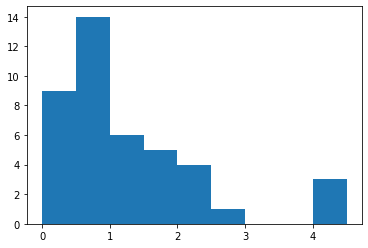

In [311]:
pivot2 = pivot.reset_index().pivot_table(values = ['cpi','tCPI'], index = 'name', aggfunc = np.mean)
pivot2['diff'] = pivot2['cpi']/pivot2['tCPI'] - 1
plt.hist(pivot2['diff'], bins = list(np.arange(0,5,.5)))